In [220]:
import os
import functools as ftools
import itertools as itools
import pandas as pd
import polars as pl
import numpy as np

import sgml, dproc, sgnn, sgutil
import tensorflow as tf
import lightgbm as lgb
import xgboost as xgb
import catboost as cb
import dill

import seaborn as sns
import matplotlib.pyplot as plt

In [221]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, roc_auc_score

In [222]:
data_path = 'data'
if not os.path.isdir(data_path):
    os.mkdir(data_path)

files = {
    k: os.path.join(p, f)
    for k, p, f in [
        ('train', data_path, 'train.csv'),
        ('test', data_path, 'test.csv'),
        ('train_parquet', data_path, 'train.parquet'),
        ('test_parquet', data_path, 'test.parquet'),
        ('var_pkl', data_path, 'var.pkl')
    ]
}

with open(os.path.join('data', 'var_w.dill'), 'rb') as f:
    df_var = dill.load(f)
df_train = pd.read_feather(os.path.join('data', 'train_w.feather'))
sc = sgutil.SGCache('img', 'result')
skf = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)
ss = StratifiedShuffleSplit(n_splits=1, train_size=0.8, random_state=123)
target = 'Depression'

In [223]:
def get_validation_splitter(validation_fraction):
    return lambda x: train_test_split(x, test_size=validation_fraction, stratify=x[target])

def print_metrics(title, m):
    print("Accuracy, {}: {:.5f}±{:.5f}".format(
        title, np.mean(m), np.std(m)
    ))

config = {
    'predict_func': lambda m, df, X: pd.Series(m.predict_proba(df[X])[:, 1], index=df.index),
    'score_func': lambda df, prds: accuracy_score(df[target].sort_index(), prds.sort_index() > 0.5),
    'validation_splitter': get_validation_splitter,
    'progress_callback': sgml.ProgressCallBack(),
    'y': target,
}

lgb_adapter = sgml.LGBMAdapter(model=lgb.LGBMClassifier)
xgb_adapter = sgml.XGBAdapter(model=xgb.XGBClassifier)
cb_adapter = sgml.CBAdapter(model=cb.CatBoostClassifier)
lr_adapter = sgml.SklearnAdapter(model=LogisticRegression)

def show_result_lgb(result):
    fig, axes = plt.subplots(1, 2, figsize=(16, 4))
    sns.barplot(
        pd.concat([i['feature_importance'] for i in result['model_result']], axis=1).mean(axis=1)\
        .sort_values(ascending=False).rename('Importance').reset_index().rename(columns={'index':'feature'}),
        x = 'Importance', y = 'feature', ax=axes[0]
    )
    if result['model_result'][0]['valid_result'] is not None:
        valid_result = pd.concat([i['valid_result'] for i in result['model_result']], axis=1).T.groupby(level=1).mean().T
        sns.lineplot(valid_result, ax=axes[1])
        if 'valid_1' in valid_result:
            axes[1].axvline(valid_result['valid_1'].idxmin())
    plt.tight_layout()
    plt.show()

In [224]:
df_var.sort_values('n_unique', ascending=False)

,min,max,na,count,n_unique,f32,i32,i16,i8,pl_type,dtype,Description,src,processor
id,0.0,234499.0,0.0,234500.0,117250.0,True,True,False,False,Int32,Int32,None,org,None
Prof_Degree,None,None,0.0,140700.0,602.0,None,None,None,None,None,Categorical,Profession_R2과 Degree_R을 결합합니다.,combine_cat,<function <lambda> at 0x7f1556ea3560>
Name,None,None,0.0,234500.0,398.0,True,True,True,True,Categorical,Categorical,None,org,None
CGPA_FZ,0.0,10.0,0.0,140700.0,332.0,True,True,True,True,None,Float32,CGPA의 결측을 0으로 채운 변수입니다.,fillna,<function get_fillna_zero_proc.<locals>.<lambd...
CGPA,5.03,10.0,187836.0,46664.0,329.5,True,True,True,True,Float32,Float32,None,org,None
Name_R,None,None,0.0,140700.0,218.0,None,None,None,None,None,Categorical,Name에서 train과 test에서 빈도가 20 미만은 Noise 처리합니다.,cat_proc,<function get_name_proc.<locals>.<lambda> at 0...
Degree,None,None,4.0,234496.0,102.0,True,True,True,True,Categorical,Categorical,None,org,None
City,None,None,0.0,234500.0,83.0,True,True,True,True,Categorical,Categorical,None,org,None
Profession,None,None,61262.0,173238.0,65.0,True,True,True,True,Categorical,Categorical,None,org,None
WS_Degree,None,None,0.0,140700.0,56.0,None,None,None,None,None,Categorical,Working Professional or Student와 Degree_R을 결합합니다.,combine_cat,<function <lambda> at 0x7f1556ea3ba0>


# LogisticRegression

In [225]:
cv_path = os.path.join('result', 'LR.cv')
if os.path.exists(cv_path):
    lr = sgml.CVModel.load('result', 'LR')
else:
    lr = sgml.CVModel('result', 'LR', skf, config, lr_adapter)

In [226]:
hparams = {
    'model_params': {'C': 1},
    'X_mm':  [
        'Age', 'Academic Pressure_FZ', 'Financial Stress_FM', 'Work Pressure_FZ', 'Study Satisfaction_FZ', 'Job Satisfaction_FZ', 'Work Hours', 
        'Study Hours', 'CGPA_FZ', 'Dietary_level', 'Sleep_level'
    ],
    'X_ohe': ['Have you ever had suicidal thoughts ?', 'WS_10', 'Family History of Mental Illness', 'Degree_R', 'City_R', 'Name_R', 'Profession_R2', 'Age_2'],
    'ohe': {'drop': 'first', 'min_frequency': 50}
}

result = lr.cv(df_train, hparams)
np.mean(result['valid_scores'])

0.9392537313432836

# LGB1

In [227]:
cv_path = os.path.join('result', 'LGB1.cv')
if os.path.exists(cv_path):
    lgb1 = sgml.CVModel.load('result', 'LGB1')
else:
    lgb1 = sgml.CVModel('result', 'LGB1', skf, config, lgb_adapter)

In [228]:
hparams = {
    'model_params': {'n_estimators': 2000, 'learning_rate': 0.02, 'num_leaves': 15, 'colsample_bytree': 0.25, 'subsample': 0.25},
    'X_num':  [
        'Age', 'Academic Pressure_FZ', 'Financial Stress_FM', 'Work Pressure_FZ', 'Study Satisfaction_FZ', 'Job Satisfaction_FZ', 'Work Hours', 
        'Study Hours', 'CGPA_FZ', 'Dietary_level', 'Sleep_level', 'Work/Study Hours'
    ],
    'X_ohe': ['Name_R', 'Have you ever had suicidal thoughts ?', 'WS_10', 'Family History of Mental Illness', 'Degree_R', 'City_R', 'Profession_R2', 'Age_2', 'Gender'],
    'ohe': {'min_frequency': 50, 'drop': 'if_binary'},
}
#result = lgb1.adhoc(df_train, ss, hparams)
#show_result_lgb(result)
#print(result['valid_scores'])

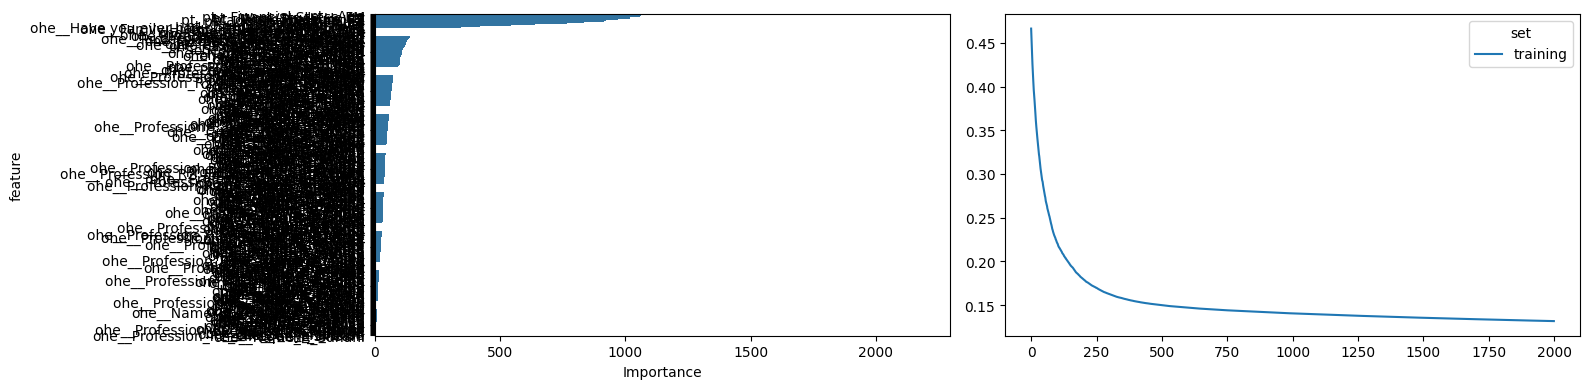

Accuracy, Valid.: 0.94043±0.00166


In [229]:
result = lgb1.cv(df_train, hparams)
show_result_lgb(result)
print_metrics('Valid.', result['valid_scores'])

,value
model_params,"{'n_estimators': 2000, 'learning_rate': 0.02, 'num_leaves': 15, 'colsample_bytree': 0.25, 'subsample': 0.25}"
X_num,"[Age, Academic Pressure_FZ, Financial Stress_FM, Work Pressure_FZ, Study Satisfaction_FZ, Job Satisfaction_FZ, Work Hours, Study Hours, CGPA_FZ, Dietary_level, Sleep_level, Work/Study Hours]"
X_ohe,"[Name_R, Have you ever had suicidal thoughts ?, WS_10, Family History of Mental Illness, Degree_R, City_R, Profession_R2, Age_2, Gender]"
ohe,"{'min_frequency': 50, 'drop': 'if_binary'}"


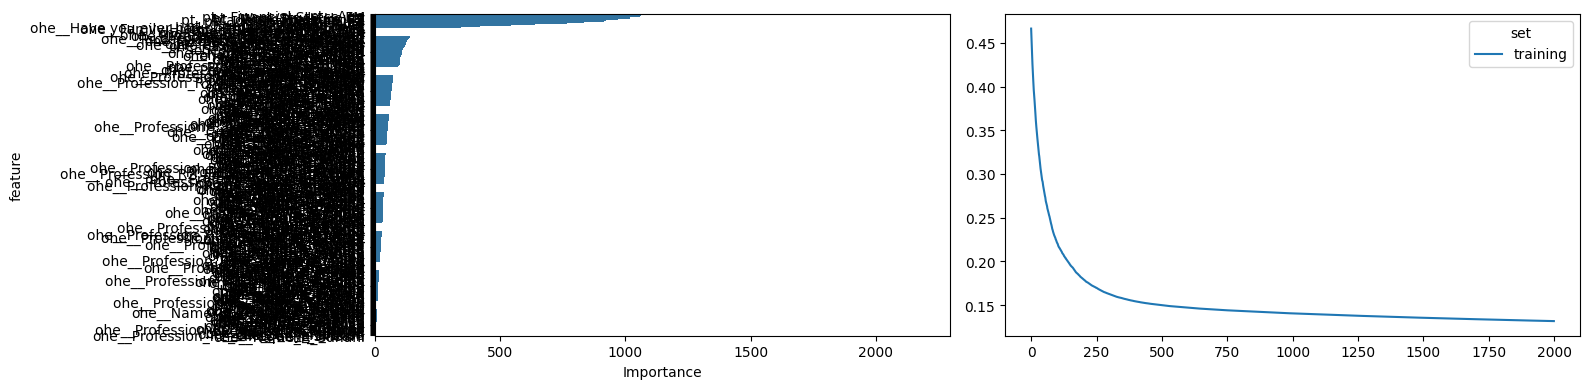

0.9404335465529495


In [230]:
with pd.option_context('display.max_colwidth', 500):
    display(pd.Series(lgb1.cv_best_['hparams']).rename('value').to_frame())
show_result_lgb(lgb1.get_best_result())
print(lgb1.cv_best_['score'])

# XGB1

In [231]:
import importlib
import sgml
importlib.reload(sgml)

<module 'sgml' from '/home/sun9sun9/jnote/sunkusun9/kaggle/PGS4_ep11/sgml.py'>

In [232]:
cv_path = os.path.join('result', 'XGB1.cv')
if os.path.exists(cv_path):
    xgb1 = sgml.CVModel.load('result', 'XGB1')
else:
    xgb1 = sgml.CVModel('result', 'XGB1', skf, config, xgb_adapter)

In [233]:
hparams = {
    'model_params': {'n_estimators': 2000, 'learning_rate': 0.04, 'max_depth': 4, 'colsample_bytree': 0.25, 'subsample': 0.25},
    'X_num':  [
        'Age', 'Academic Pressure', 'Financial Stress', 'Work Pressure', 'Study Satisfaction', 'Job Satisfaction', 'Work Hours', 
        'Study Hours', 'CGPA', 'Dietary_level', 'Sleep_level'
    ],
    'X_ohe': ['Name_R', 'Have you ever had suicidal thoughts ?', 'WS_10', 'Family History of Mental Illness', 'Degree_R', 'City_R', 'Profession_R2', 'Age_2', 'Gender', 'Age_18_Unknown'],
    'ohe': {'min_frequency': 50, 'drop': 'if_binary'},
    # 'validation_fraction': 0.1
}
# xgb1.adhoc(df_train, ss, hparams, device='cuda')

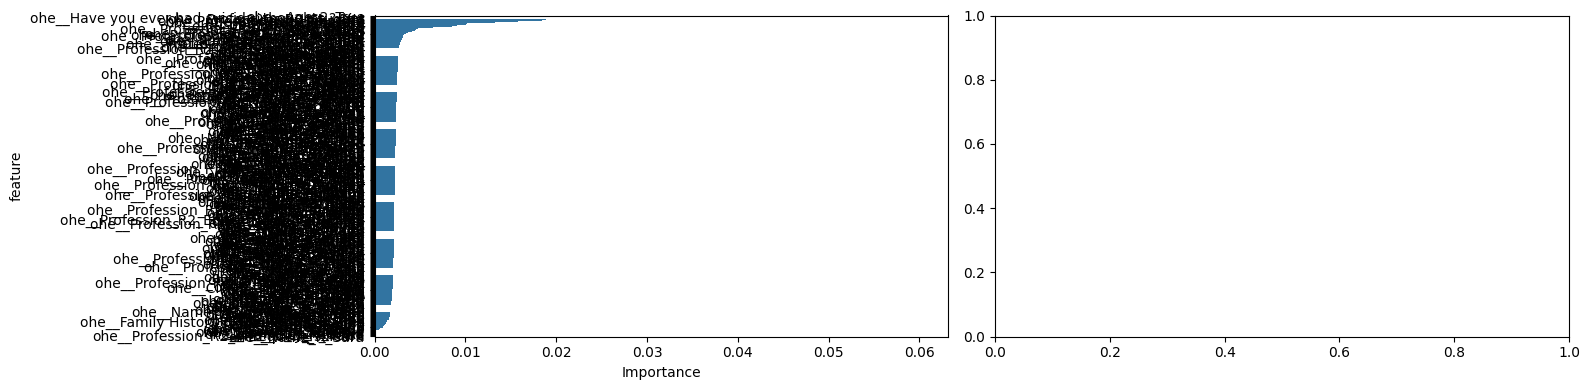

Accuracy, Valid.: 0.94032±0.00132


In [234]:
result = xgb1.cv(df_train, hparams, device='cuda')
show_result_lgb(result)
print_metrics('Valid.', result['valid_scores'])

,value
model_params,"{'n_estimators': 2000, 'learning_rate': 0.04, 'max_depth': 4, 'colsample_bytree': 0.25, 'subsample': 0.25}"
X_num,"[Age, Academic Pressure, Financial Stress, Work Pressure, Study Satisfaction, Job Satisfaction, Work Hours, Study Hours, CGPA, Dietary_level, Sleep_level]"
X_ohe,"[Name_R, Have you ever had suicidal thoughts ?, WS_10, Family History of Mental Illness, Degree_R, City_R, Profession_R2, Age_2, Gender, Age_18_Unknown]"
ohe,"{'min_frequency': 50, 'drop': 'if_binary'}"


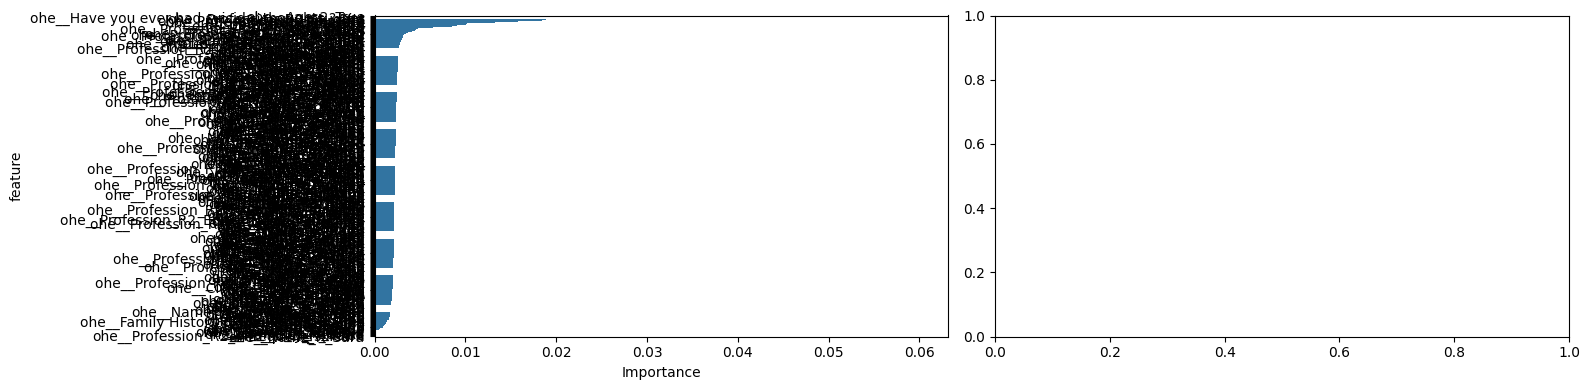

0.9403198294243069


In [235]:
with pd.option_context('display.max_colwidth', 500):
    display(pd.Series(xgb1.cv_best_['hparams']).rename('value').to_frame())
show_result_lgb(xgb1.get_best_result())
print(xgb1.cv_best_['score'])

# XGB2

In [236]:
cv_path = os.path.join('result', 'XGB2.cv')
if os.path.exists(cv_path):
    xgb2 = sgml.CVModel.load('result', 'XGB2')
else:
    xgb2 = sgml.CVModel('result', 'XGB2', skf, config, xgb_adapter)

In [237]:
hparams = {
    'model_params': {'n_estimators': 2000, 'learning_rate': 0.06, 'max_depth': 3, 'colsample_bytree': 0.25, 'subsample': 0.25},
    'X_num':  [
        'Age', 'Academic Pressure', 'Financial Stress', 'Work Pressure', 'Study Satisfaction', 'Job Satisfaction', 'Work Hours', 
        'Study Hours', 'CGPA', 'Dietary_level', 'Sleep_level'
    ],
    'X_ohe': ['Name_R', 'Have you ever had suicidal thoughts ?', 'WS_10', 'Family History of Mental Illness', 'Degree_R', 'City_R', 'Profession_R2', 'Age_2', 'Gender'],
    'ohe': {'min_frequency': 50, 'drop': 'if_binary'},
    # 'validation_fraction': 0.1
}
# xgb2.adhoc(df_train, ss, hparams, device='cuda')

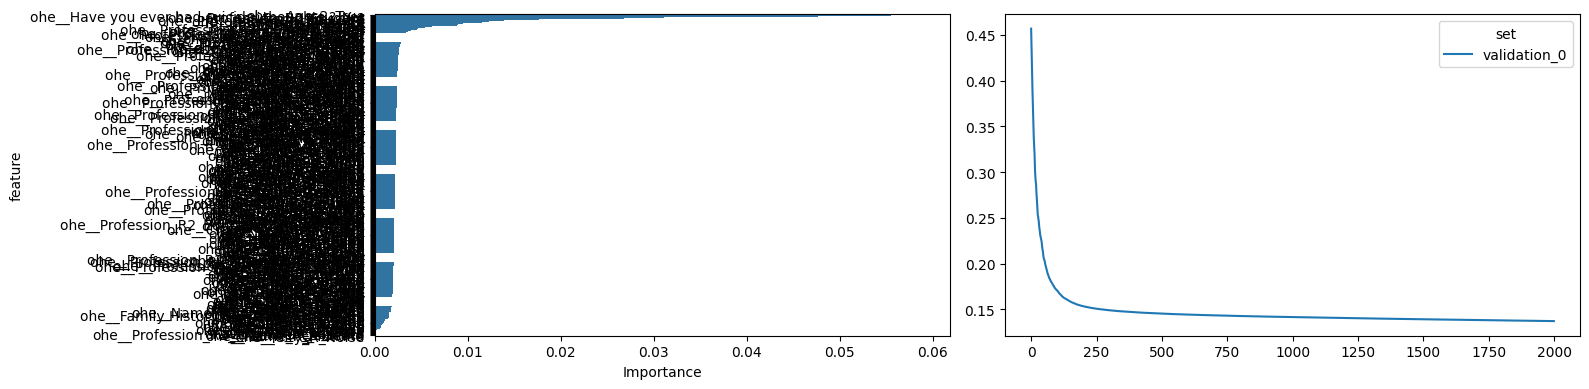

Accuracy, Valid.: 0.94024±0.00120


In [238]:
result = xgb2.cv(df_train, hparams, device='cuda')
show_result_lgb(result)
print_metrics('Valid.', result['valid_scores'])

,value
model_params,"{'n_estimators': 2000, 'learning_rate': 0.04, 'max_depth': 4, 'colsample_bytree': 0.25, 'subsample': 0.25}"
X_num,"[Age, Academic Pressure, Financial Stress, Work Pressure, Study Satisfaction, Job Satisfaction, Work Hours, Study Hours, CGPA, Dietary_level, Sleep_level]"
X_ohe,"[Name_R, Have you ever had suicidal thoughts ?, WS_10, Family History of Mental Illness, Degree_R, City_R, Profession_R2, Age_2, Gender, Age_18_Unknown]"
ohe,"{'min_frequency': 50, 'drop': 'if_binary'}"


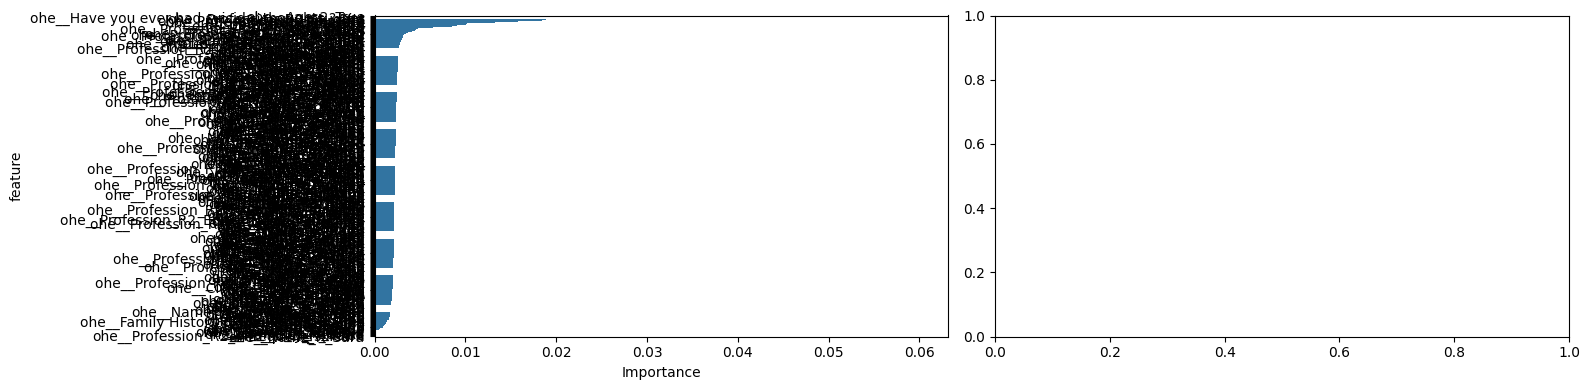

0.9403198294243069


In [239]:
with pd.option_context('display.max_colwidth', 500):
    display(pd.Series(xgb1.cv_best_['hparams']).rename('value').to_frame())
show_result_lgb(xgb1.get_best_result())
print(xgb1.cv_best_['score'])

# CB

In [240]:
cv_path = os.path.join('result', 'CB1.cv')
if os.path.exists(cv_path):
    cb1 = sgml.CVModel.load('result', 'CB1')
else:
    cb1 = sgml.CVModel('result', 'CB1', skf, config, cb_adapter)

In [241]:
hparams = {
    'model_params': {'n_estimators': 2000, 'learning_rate': 0.05, 'max_depth': 5, 'rsm': 0.5},
    'X_num':  [
        'Age', 'Academic Pressure', 'Financial Stress', 'Work Pressure', 'Study Satisfaction', 'Job Satisfaction', 'Work Hours', 
        'Study Hours', 'CGPA_FZ', 'Dietary_level', 'Sleep_level'
    ],
    'X_cat': ['Name_R', 'Have you ever had suicidal thoughts ?', 'WS_10', 'Family History of Mental Illness', 'Degree_R', 'City_R', 'Profession_R2', 'Age_2', 'Gender', 'Age_18_Unknown'],
}
# cb1.adhoc(df_train, ss, hparams)

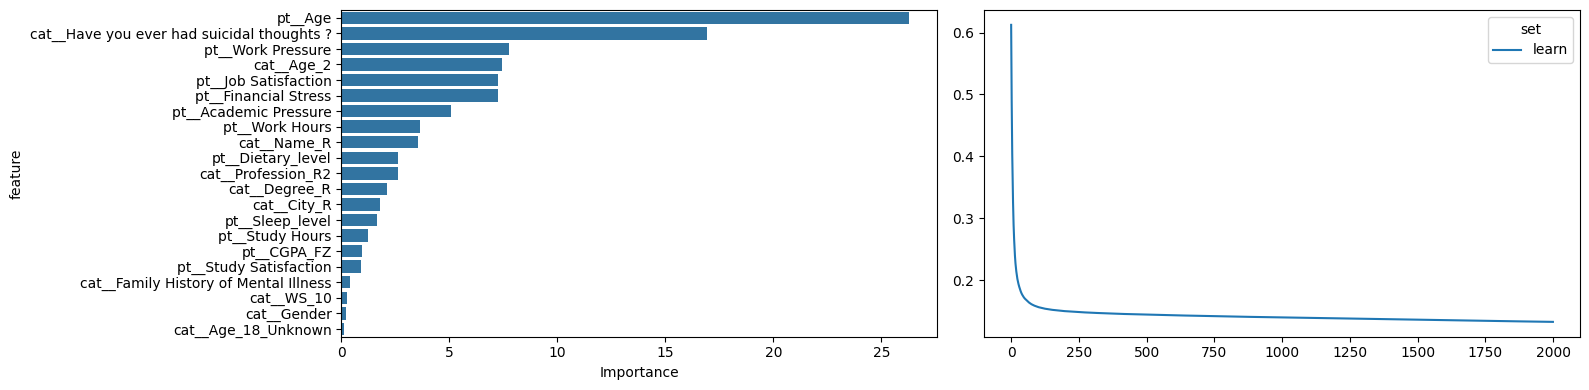

Accuracy, Valid.: 0.94072±0.00181


In [242]:
result = cb1.cv(df_train, hparams)
show_result_lgb(result)
print_metrics('Valid.', result['valid_scores'])

,value
model_params,"{'n_estimators': 2000, 'learning_rate': 0.05, 'max_depth': 5, 'rsm': 0.5}"
X_num,"[Age, Academic Pressure, Financial Stress, Work Pressure, Study Satisfaction, Job Satisfaction, Work Hours, Study Hours, CGPA_FZ, Dietary_level, Sleep_level]"
X_cat,"[Name_R, Have you ever had suicidal thoughts ?, WS_10, Family History of Mental Illness, Degree_R, City_R, Profession_R2, Age_2, Gender, Age_18_Unknown]"


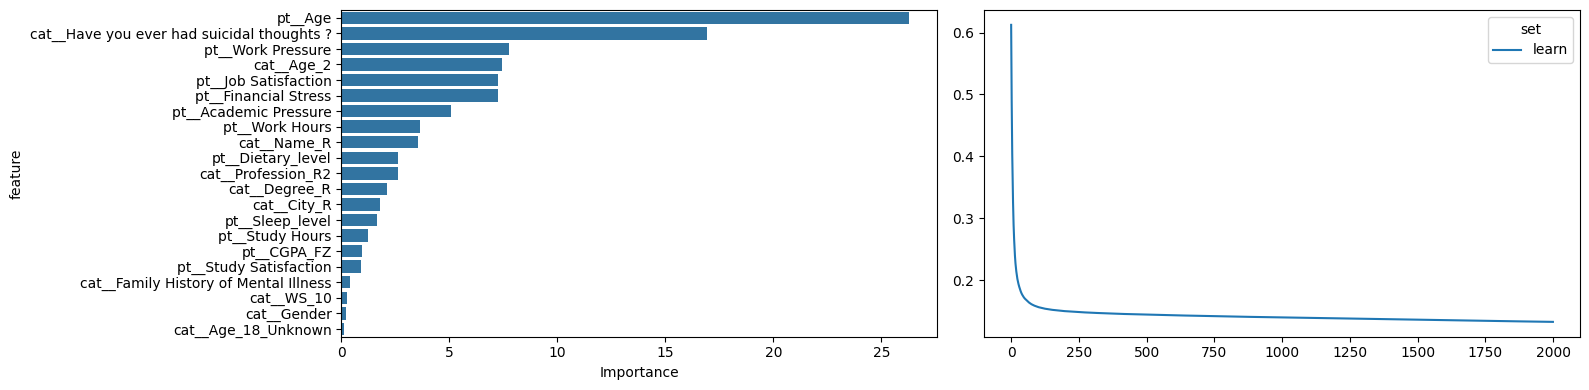

0.940724946695096


In [243]:
with pd.option_context('display.max_colwidth', 500):
    display(pd.Series(cb1.cv_best_['hparams']).rename('value').to_frame())
show_result_lgb(cb1.get_best_result())
print(cb1.cv_best_['score'])

# NN

In [244]:
import sgnn
nn_adapter = sgnn.NNAdapter(model=sgnn.NNClassifier)

In [245]:
cv_path = os.path.join('result', 'NN1.cv')
if os.path.exists(cv_path):
    nn1 = sgml.CVModel.load('result', 'NN1')
else:
    nn1 = sgml.CVModel('result', 'NN1', skf, config, nn_adapter)

In [246]:
def nn_cat_param(df, name, size):
    return name, len(df[name].cat.categories), size

X_cat = ['Name_R', 'City_R', 'Profession_R2', 'Degree_R']
X_nn_emb = [
    ('Name_R', 3), ('City_R', 2), ('Profession_R2', 2), ('Degree_R', 2)
]

nn_params = {
    'embedding':[(1, c, es, 0, 0) for _, c, es in [nn_cat_param(df_train, v, n) for v, n in X_nn_emb]], 
    'config':  [
        {'unit': 4, 'activation': 'relu', 'batch_norm': False},
#        {'unit': 4, 'activation': 'relu', 'batch_norm': False},
    ]
}

hparams = {
    'model_params': {
        'model_params': nn_params,
        'epochs': 30,
        'optimizer': ('Adam', {'learning_rate': 0.002}),
        'batch_size': 2048, 'shuffle_size': 102400,
        'early_stopping': None, 'reduce_lr_on_plateau': None, 'lr_scheduler': None
    }, 
    'X_cat': [i for i, _ in X_nn_emb],
    'X_std':  [
        'Age', 'Academic Pressure_FZ', 'Financial Stress_FM', 'Work Pressure_FZ', 'Study Satisfaction_FZ', 'Job Satisfaction_FZ', 'Work Hours', 
        'Study Hours', 'CGPA_FZ', 'Dietary_level', 'Sleep_level'
    ],
    'X_ohe': ['Have you ever had suicidal thoughts ?', 'WS_10', 'Family History of Mental Illness', 'Age_2'],
    'ohe': {'drop': 'first', 'min_frequency': 50, 'sparse_output': False},
    #'validation_fraction': 0.1
}

# nn1.adhoc(df_train, ss, hparams)

In [247]:
"""
class DepressionModel(tf.keras.Model):
    def __init__(self, emb_cols, cont_cols, f_size, left_layers, right_layers, top_layers):
        super().__init__()
        if emb_cols != None:
            self.emb_layers = {
                v.replace(' ', '_').replace('?', '_'): tf.keras.layers.Embedding(c, s, name=v.replace(' ', '_').replace('?', '_')) for v, c, s in emb_cols
            }
            self.emb_cc = tf.keras.layers.Concatenate(axis=-1)
            if left_layers != None:
                self.left_model = tf.keras.models.Sequential([
                    tf.keras.layers.Dropout(**params) if 'rate' in params else tf.keras.layers.Dense(**params) for params in left_layers
                ])
                self.right_model = tf.keras.models.Sequential([
                    tf.keras.layers.Dropout(**params) if 'rate' in params else tf.keras.layers.Dense(**params) for params in right_layers
                ])
                self.mul = tf.keras.layers.Multiply()
                self.left_slice_layer_1 = tf.keras.layers.Lambda(lambda x: x[:, :f_size])
                self.left_slice_layer_2 = tf.keras.layers.Lambda(lambda x: x[:, f_size:])
                self.right_slice_layer_1 = tf.keras.layers.Lambda(lambda x: x[:, :f_size])
                self.right_slice_layer_2 = tf.keras.layers.Lambda(lambda x: x[:, f_size:])
            else:
                self.left_model = None
        else:
            self.emb_layers = None
        self.top_cc = tf.keras.layers.Concatenate(axis=-1)
        self.top_model = tf.keras.models.Sequential([
            tf.keras.layers.Dropout(**params) if 'rate' in params else tf.keras.layers.Dense(**params) for params in top_layers
        ])
        self.f_size = f_size
        self.cont_cols = cont_cols
        self.sigmoid = tf.keras.layers.Activation('sigmoid')

    def __call__(self, X):
        if self.emb_layers != None:
            X_emb = self.emb_cc([tf.squeeze(v(X[k]), axis=-2) for k, v in self.emb_layers.items()])
            if self.left_model !=None:
                X_left = self.left_model(X_emb)
                X_right = self.right_model(X_emb)
                X_left_1 = self.left_slice_layer_1(X_left)
                X_left_2 = self.left_slice_layer_2(X_left)
                
                X_right_1 = self.right_slice_layer_1(X_right)
                X_right_2 = self.right_slice_layer_2(X_right)
                X_mul = self.mul([X_left_1, X_right_1])
                cc_list = [X_left_2, X_right_2, X_mul]
            else:
                cc_list = [X_emb]
        else:
            cc_list = list()
        if self.cont_cols != None:
            cc_list.append(X[self.cont_cols])
        if len(cc_list) == 1:
            return self.sigmoid(
                self.top_model(cc_list[0])
            )
        else:
            return self.sigmoid(
                self.top_model(self.top_cc(cc_list))
            )

def to_tf_dataset(X, Y=None, sample_weights=None, cont=[], cat=[]):
    d = {}
    c = 0
    for i in cat:
        d[i.replace(' ', '_').replace('?', '_')] = np.expand_dims(X[:, c].astype('int'), axis=-1)
        c += 1
        
    if len(cont) > 0:
        d['Continous'] =  X[:, c:]
    if Y is None:
        return tf.data.Dataset.from_tensor_slices(d)
    else:
        if type(Y) == pd.Series:
            if sample_weights is None:
                return tf.data.Dataset.from_tensor_slices((d, Y.values))
            else:
                return tf.data.Dataset.from_tensor_slices((d, Y.values, sample_weights.values))
        else:
            if sample_weights is None:
                return tf.data.Dataset.from_tensor_slices((d, Y))
            else:
                return tf.data.Dataset.from_tensor_slices((d, Y, sample_weights))

def nn_cat_param(df, name, size):
    return name, len(df[name].cat.categories), size


X_cat = ['Name_R', 'City_R', 'Profession_R2', 'Degree_R', 'Sleep Duration_R', 'Dietary Habits_R', 
         'Working Professional or Student', 'Have you ever had suicidal thoughts ?', 'Gender', 'Family History of Mental Illness']
X_num = ['CGPA_FZ', 'Work Hours', 'Study Hours', 'Work Pressure_FZ', 'Academic Pressure_FZ', 
         'Study Satisfaction_FZ', 'Job Satisfaction_FZ', 'Age', 'Financial Stress_FM', 'Sleep_level', 'Dietary_level']
X_nn_emb = [
    ('Name_R', 2), ('City_R', 2), ('Profession_R2', 2), ('Degree_R', 2), ('Sleep Duration_R', 1), ('Dietary Habits_R', 1), ('Working Professional or Student', 1), 
    ('Have you ever had suicidal thoughts ?', 1), ('Gender', 1), ('Family History of Mental Illness', 1)
]

nn_adapter = sgnn.NNAdapter(
    model=sgnn.NNClassifier,
    to_tf_dataset = ftools.partial(
        to_tf_dataset, 
        cont=X_num,
        cat=X_cat
    )
)
"""
' '

' '

In [248]:
"""nn_params = {
    'emb_cols': [
        nn_cat_param(df_train, v, n) for v, n in X_nn_emb
    ], 
    'cont_cols':  'Continous',
    'f_size':  16, 
    'left_layers': [
        {'units': 64, 'activation': 'relu', 'kernel_initializer': 'he_uniform'}, 
        #{'units': 32, 'activation': 'relu', 'kernel_initializer': 'he_uniform'}, 
        {'units': 32, 'kernel_initializer': 'glorot_uniform'}
    ], 
    'right_layers': [
        {'units': 64, 'activation': 'relu', 'kernel_initializer': 'he_uniform'}, 
        #{'units': 32, 'activation': 'relu', 'kernel_initializer': 'he_uniform'}, 
        {'units': 32, 'kernel_initializer': 'glorot_uniform'}
    ], 
    'top_layers': [
        {'units': 32, 'activation': 'relu', 'kernel_initializer': 'he_uniform'}, 
        {'rate': 0.25},
        {'units': 16, 'activation': 'relu', 'kernel_initializer': 'he_uniform'}, 
        {'rate': 0.25},
        {'units': 1, 'kernel_initializer': 'glorot_uniform'}
    ]
}

hparams = {
    'model_params': {
        'model': DepressionModel, 
        'model_params': nn_params,
        'epochs': 30,
        'optimizer': ('Adam', {'learning_rate': 0.0005}),
        'batch_size': 512, 'shuffle_size': 102400,
        'early_stopping': None, 'reduce_lr_on_plateau': None, 'lr_scheduler': None
    }, 
    'X_std': X_num,
    'X_cat': X_cat,
    'ohe': {'drop': 'first'}
}
nn1.adhoc(df_train, ss, hparams)
"""
' '

' '

In [249]:
result = nn1.cv(df_train, hparams)
print_metrics('Valid.', result['valid_scores'])

Accuracy, Valid.: 0.93942±0.00140


In [250]:
with pd.option_context('display.max_colwidth', 500):
    display(pd.Series(nn1.cv_best_['hparams']).rename('value').to_frame())
print(nn1.cv_best_['score'])

,value
model_params,"{'model_params': {'embedding': [(1, 218, 3, 0, 0), (1, 31, 2, 0, 0), (1, 38, 2, 0, 0), (1, 28, 2, 0, 0)], 'config': [{'unit': 4, 'activation': 'relu', 'batch_norm': False}]}, 'epochs': 30, 'optimizer': ('Adam', {'learning_rate': 0.002}), 'batch_size': 2048, 'shuffle_size': 102400, 'early_stopping': None, 'reduce_lr_on_plateau': None, 'lr_scheduler': None}"
X_cat,"[Name_R, City_R, Profession_R2, Degree_R]"
X_std,"[Age, Academic Pressure_FZ, Financial Stress_FM, Work Pressure_FZ, Study Satisfaction_FZ, Job Satisfaction_FZ, Work Hours, Study Hours, CGPA_FZ, Dietary_level, Sleep_level]"
X_ohe,"[Have you ever had suicidal thoughts ?, WS_10, Family History of Mental Illness, Age_2]"
ohe,"{'drop': 'first', 'min_frequency': 50, 'sparse_output': False}"


0.9394243070362472


# LGB + LDA

In [251]:
cv_path = os.path.join('result', 'LGB_LDA.cv')
if os.path.exists(cv_path):
    lgb_lda = sgml.CVModel.load('result', 'LGB_LDA')
else:
    lgb_lda = sgml.CVModel('result', 'LGB_LDA', skf, config, lgb_adapter)

In [252]:
hparams = {
    'model_params': {
        'n_estimators': 2000, 
        'num_leaves': 7,
        'learning_rate': 0.04,
        'random_state' : 123,
        'colsample_bytree' : 0.25,
        'subsample': 0.25
    }, 
    'X_num':  [
        'Age', 'Academic Pressure_FZ', 'Financial Stress_FM', 'Work Pressure_FZ', 'Study Satisfaction_FZ', 'Job Satisfaction_FZ', 'Work Hours', 
        'Study Hours', 'CGPA_FZ', 'Dietary_level', 'Sleep_level'
    ],
    'X_ohe': ['Name_R', 'Have you ever had suicidal thoughts ?', 'WS_10', 'Family History of Mental Illness', 'Degree_R', 'City_R', 'Profession_R2', 'Age_2', 'Gender'],
    'ohe': {'min_frequency': 50, 'drop': 'if_binary'},
    'lda': {
        'X_mm':  [
            'Academic Pressure_FZ', 'Study Hours', 'CGPA_FZ', 'Work Hours', 'Academic Pressure_FZ', 'Financial Stress_FM', 'Work Pressure_FZ', 'Study Satisfaction_FZ', 'Job Satisfaction_FZ'
        ],
    }
}
# result = lgb_lda.adhoc(df_train, ss, hparams)
# show_result_lgb(result)
# print(result['valid_scores'])

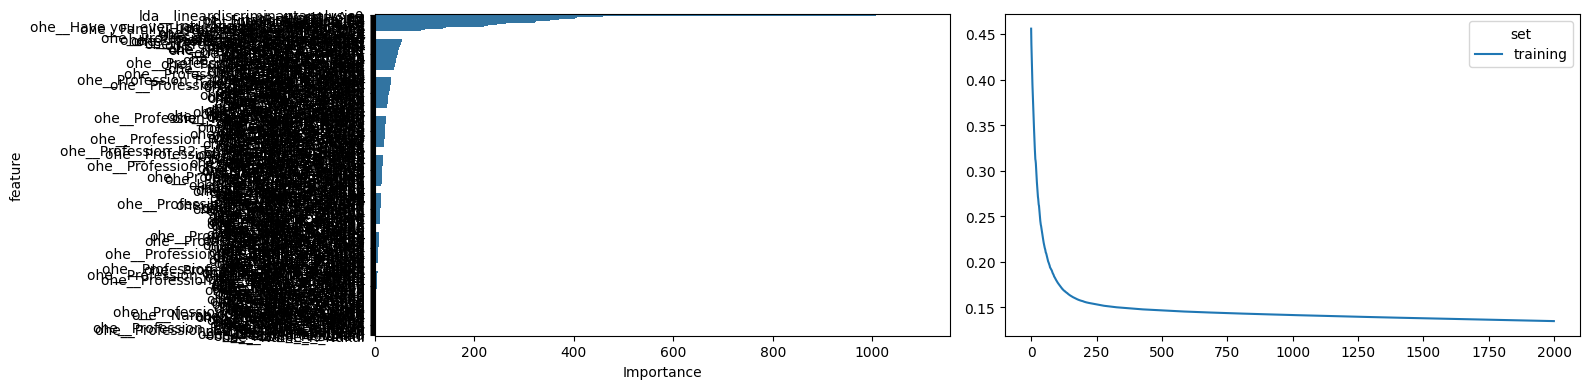

Accuracy, Valid.: 0.94007±0.00149


In [253]:
result = lgb_lda.cv(df_train, hparams)
show_result_lgb(result)
print_metrics('Valid.', result['valid_scores'])

In [254]:
with pd.option_context('display.max_colwidth', 500):
    display(pd.Series(lgb_lda.cv_best_['hparams']).rename('value').to_frame())
print(lgb_lda.cv_best_['score'])

,value
model_params,"{'n_estimators': 2000, 'num_leaves': 7, 'learning_rate': 0.04, 'random_state': 123, 'colsample_bytree': 0.25, 'subsample': 0.25}"
X_num,"[Age, Academic Pressure_FZ, Financial Stress_FM, Work Pressure_FZ, Study Satisfaction_FZ, Job Satisfaction_FZ, Work Hours, Study Hours, CGPA_FZ, Dietary_level, Sleep_level]"
X_ohe,"[Name_R, Have you ever had suicidal thoughts ?, WS_10, Family History of Mental Illness, Degree_R, City_R, Profession_R2, Age_2, Gender]"
ohe,"{'min_frequency': 50, 'drop': 'if_binary'}"
lda,"{'X_mm': ['Academic Pressure_FZ', 'Study Hours', 'CGPA_FZ', 'Work Hours', 'Academic Pressure_FZ', 'Financial Stress_FM', 'Work Pressure_FZ', 'Study Satisfaction_FZ', 'Job Satisfaction_FZ']}"


0.9400710732054016


# LGB2

num_leaves를 15 → 7로 낮추어 모델을 구성합니다.

In [255]:
cv_path = os.path.join('result', 'LGB2.cv')
if os.path.exists(cv_path):
    lgb2 = sgml.CVModel.load('result', 'LGB2')
else:
    lgb2 = sgml.CVModel('result', 'LGB2', skf, config, lgb_adapter)

In [256]:
hparams = {
    'model_params': {'n_estimators': 2000, 'learning_rate': 0.04, 'num_leaves': 7, 'colsample_bytree': 0.25, 'subsample': 0.25},
    'X_num':  [
        'Age', 'Academic Pressure_FZ', 'Financial Stress_FM', 'Work Pressure_FZ', 'Study Satisfaction_FZ', 'Job Satisfaction_FZ', 'Work Hours', 
        'Study Hours', 'CGPA_FZ', 'Dietary_level', 'Sleep_level', 'Work/Study Hours'
    ],
    'X_ohe': ['Name_R', 'Have you ever had suicidal thoughts ?', 'WS_10', 'Family History of Mental Illness', 'Degree_R', 'City_R', 'Profession_R2', 'Age_2', 'Gender'],
    'ohe': {'min_frequency': 50, 'drop': 'if_binary'},
}
#result = lgb2.adhoc(df_train, ss, hparams)
#show_result_lgb(result)
#print(result['valid_scores'])

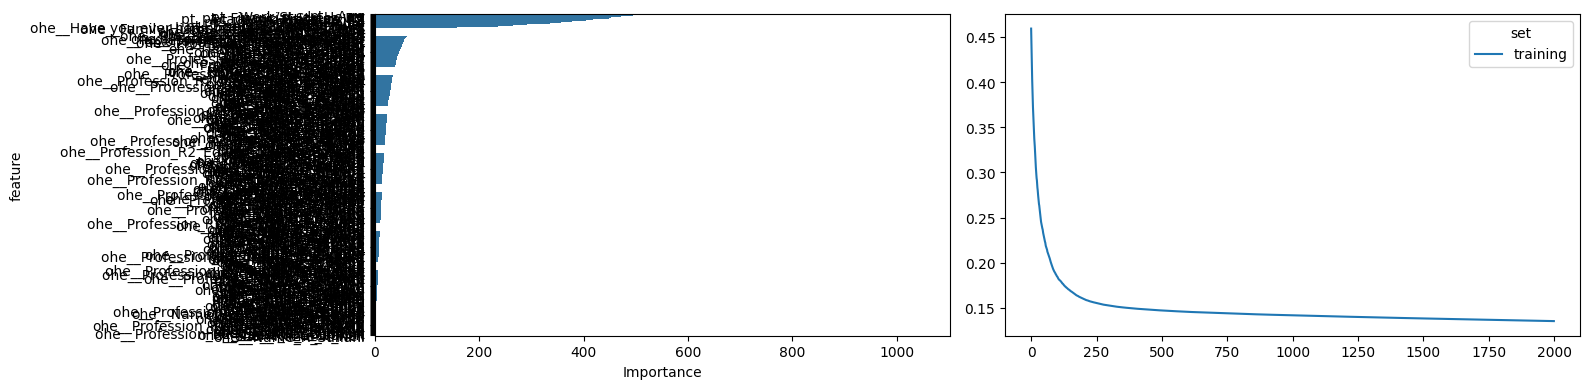

Accuracy, Valid.: 0.94033±0.00192


In [257]:
result = lgb2.cv(df_train, hparams)
show_result_lgb(result)
print_metrics('Valid.', result['valid_scores'])

In [258]:
with pd.option_context('display.max_colwidth', 500):
    display(pd.Series(lgb2.cv_best_['hparams']).rename('value').to_frame())
print(lgb2.cv_best_['score'])

,value
model_params,"{'n_estimators': 2000, 'learning_rate': 0.04, 'num_leaves': 7, 'colsample_bytree': 0.25, 'subsample': 0.25}"
X_num,"[Age, Academic Pressure_FZ, Financial Stress_FM, Work Pressure_FZ, Study Satisfaction_FZ, Job Satisfaction_FZ, Work Hours, Study Hours, CGPA_FZ, Dietary_level, Sleep_level, Work/Study Hours]"
X_ohe,"[Name_R, Have you ever had suicidal thoughts ?, WS_10, Family History of Mental Illness, Degree_R, City_R, Profession_R2, Age_2, Gender]"
ohe,"{'min_frequency': 50, 'drop': 'if_binary'}"


0.9403340440653875


# XGB + LDA

In [259]:
cv_path = os.path.join('result', 'XGB_LDA.cv')
if os.path.exists(cv_path):
    xgb_lda = sgml.CVModel.load('result', 'XGB_LDA')
else:
    xgb_lda = sgml.CVModel('result', 'XGB_LDA', skf, config, xgb_adapter)

In [260]:
hparams = {
    'model_params': {'n_estimators': 2000, 'learning_rate': 0.06, 'max_depth': 3, 'colsample_bytree': 0.25, 'subsample': 0.25},
    'X_num':  [
        'Age', 'Academic Pressure_FZ', 'Financial Stress_FM', 'Work Pressure_FZ', 'Study Satisfaction_FZ', 'Job Satisfaction_FZ', 'Work Hours', 
        'Study Hours', 'Dietary_level', 'Sleep_level'
    ],
    'X_ohe': ['Name_R', 'Have you ever had suicidal thoughts ?', 'WS_10', 'Family History of Mental Illness', 'Degree_R', 'City_R', 'Profession_R2', 'Age_2', 'Age_18_Unknown'],
    'ohe': {'min_frequency': 50, 'drop': 'if_binary'},
    'lda': {
        'X_mm':  [
            'Academic Pressure_FZ', 'Study Hours', 'CGPA_FZ', 'Work Hours', 'Academic Pressure_FZ', 'Financial Stress_FM', 'Work Pressure_FZ', 'Study Satisfaction_FZ', 'Job Satisfaction_FZ',
            'Dietary_level', 'Sleep_level'
        ],
    },
}
# result = xgb_lda.adhoc(df_train, ss, hparams, device='cuda')
# show_result_lgb(result)
# print(result['train_scores'], result['valid_scores'])

Fold:   0%|          | 0/5 [00:00<?, ?it/s]

Round:   0%|          | 0/2000 [00:00<?, ?it/s]

Round:   0%|          | 0/2000 [00:00<?, ?it/s]

Round:   0%|          | 0/2000 [00:00<?, ?it/s]

Round:   0%|          | 0/2000 [00:00<?, ?it/s]

Round:   0%|          | 0/2000 [00:00<?, ?it/s]

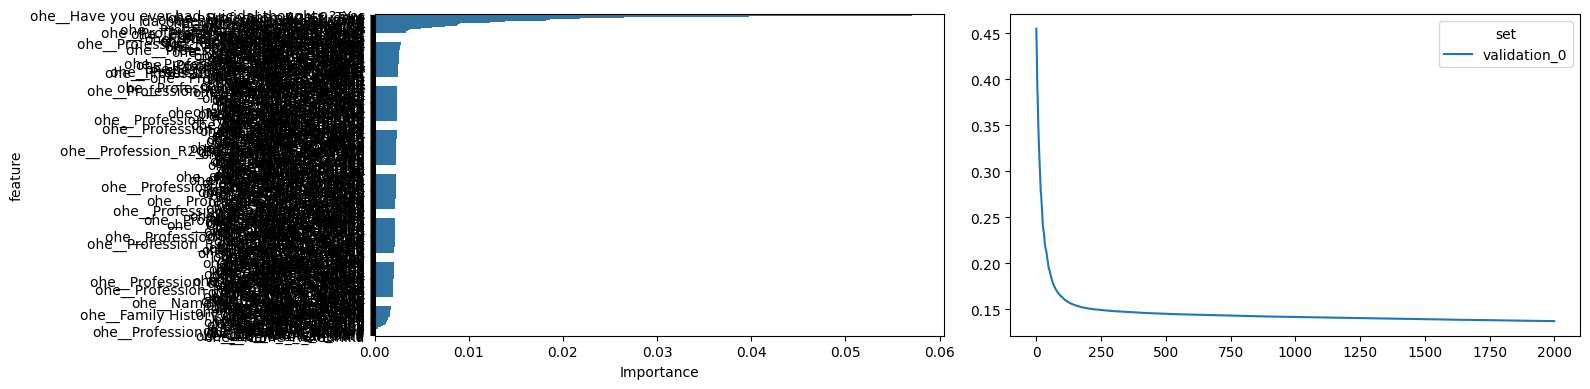

Accuracy, Valid.: 0.93990±0.00120


In [261]:
result = xgb_lda.cv(df_train, hparams, device='cuda')
show_result_lgb(result)
print_metrics('Valid.', result['valid_scores'])

In [262]:
with pd.option_context('display.max_colwidth', 500):
    display(pd.Series(xgb_lda.cv_best_['hparams']).rename('value').to_frame())
print(xgb_lda.cv_best_['score'])

,value
model_params,"{'n_estimators': 2000, 'learning_rate': 0.06, 'max_depth': 3, 'colsample_bytree': 0.25, 'subsample': 0.25}"
X_num,"[Age, Academic Pressure_FZ, Financial Stress_FM, Work Pressure_FZ, Study Satisfaction_FZ, Job Satisfaction_FZ, Work Hours, Study Hours, Dietary_level, Sleep_level]"
X_ohe,"[Name_R, Have you ever had suicidal thoughts ?, WS_10, Family History of Mental Illness, Degree_R, City_R, Profession_R2, Age_2]"
ohe,"{'min_frequency': 50, 'drop': 'if_binary'}"
lda,"{'X_mm': ['Academic Pressure_FZ', 'Study Hours', 'CGPA_FZ', 'Work Hours', 'Academic Pressure_FZ', 'Financial Stress_FM', 'Work Pressure_FZ', 'Study Satisfaction_FZ', 'Job Satisfaction_FZ', 'Dietary_level', 'Sleep_level']}"


0.940270078180526


# CB2

In [263]:
cv_path = os.path.join('result', 'CB2.cv')
if os.path.exists(cv_path):
    cb2 = sgml.CVModel.load('result', 'CB2')
else:
    cb2 = sgml.CVModel('result', 'CB2', skf, config, cb_adapter)

In [264]:
hparams = {
    'model_params': {'n_estimators': 2000, 'learning_rate': 0.07, 'max_depth': 4, 'rsm': 0.5},
    'X_num':  [
        'Age', 'Academic Pressure', 'Financial Stress', 'Work Pressure', 'Study Satisfaction', 'Job Satisfaction', 'Work Hours', 
        'Study Hours', 'CGPA_FZ', 'Dietary_level', 'Sleep_level'
    ],
    'X_cat': ['Name_R', 'Have you ever had suicidal thoughts ?', 'WS_10', 'Family History of Mental Illness', 'Degree_R', 'City_R', 'Profession_R2', 'Age_2', 'Gender'],
    #'validation_fraction': 0.1
}
#result = cb2.adhoc(df_train, ss, hparams)
#show_result_lgb(result)
#print(result['train_scores'], result['valid_scores'])

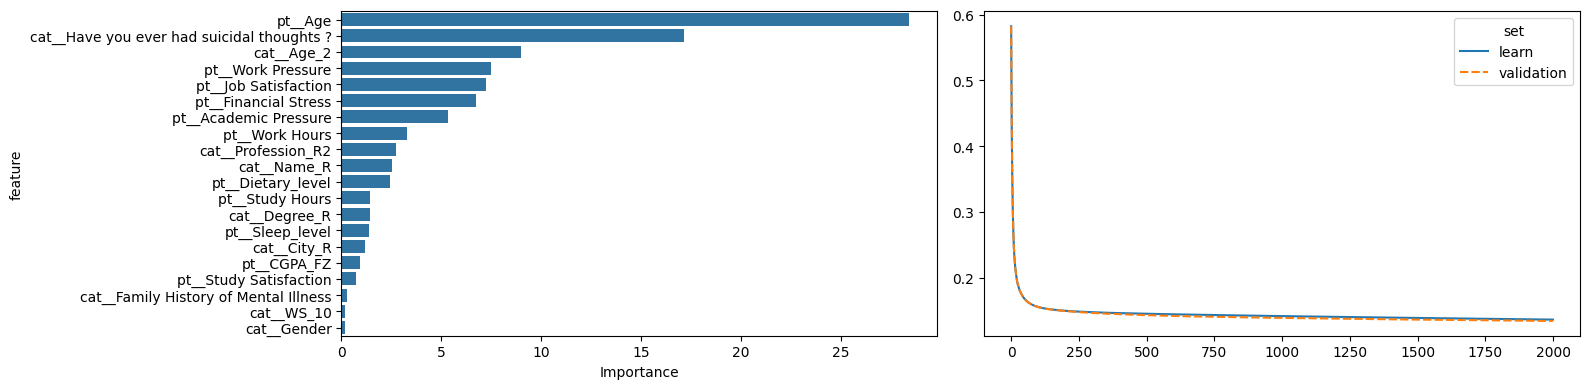

Accuracy, Valid.: 0.94043±0.00197


In [265]:
result = cb2.cv(df_train, hparams)
show_result_lgb(result)
print_metrics('Valid.', result['valid_scores'])

In [266]:
with pd.option_context('display.max_colwidth', 500):
    display(pd.Series(cb2.cv_best_['hparams']).rename('value').to_frame())
print(cb2.cv_best_['score'])

,value
model_params,"{'n_estimators': 2000, 'max_depth': 4, 'learning_rate': 0.07, 'random_state': 123, 'rsm': 0.75}"
X_num,"[CGPA, Pressure, Satisfaction, Work/Study Hours, Work Pressure, Academic Pressure, Study Satisfaction, Job Satisfaction, Age, Financial Stress, Financial Stress_Age]"
X_cat,"[Name_R, City_R, Prof_Degree, WS_Degree, Profession_R2, Degree_R, Working Professional or Student, Have you ever had suicidal thoughts ?, Gender, Family History of Mental Illness, Sleep Duration_R, Dietary Habits_R]"


0.9404406538734896


# CB3

In [267]:
cv_path = os.path.join('result', 'CB3.cv')
if os.path.exists(cv_path):
    cb3 = sgml.CVModel.load('result', 'CB3')
else:
    cb3 = sgml.CVModel('result', 'CB3', skf, config, cb_adapter)

In [268]:
hparams = {
    'model_params': {'n_estimators': 1800, 'learning_rate': 0.05, 'max_depth': 6, 'rsm': 0.5},
    'X_num':  [
        'Age', 'Academic Pressure', 'Financial Stress', 'Work Pressure', 'Study Satisfaction', 'Job Satisfaction', 'Work Hours', 
        'Study Hours', 'CGPA_FZ', 'Dietary_level', 'Sleep_level'
    ],
    'X_cat': ['Name_R', 'Have you ever had suicidal thoughts ?', 'WS_10', 'Family History of Mental Illness', 'Degree_R', 'City_R', 'Profession_R2', 'Age_2', 'Gender'],
    #'validation_fraction': 0.1
}
# cb3.adhoc(df_train, ss, hparams)

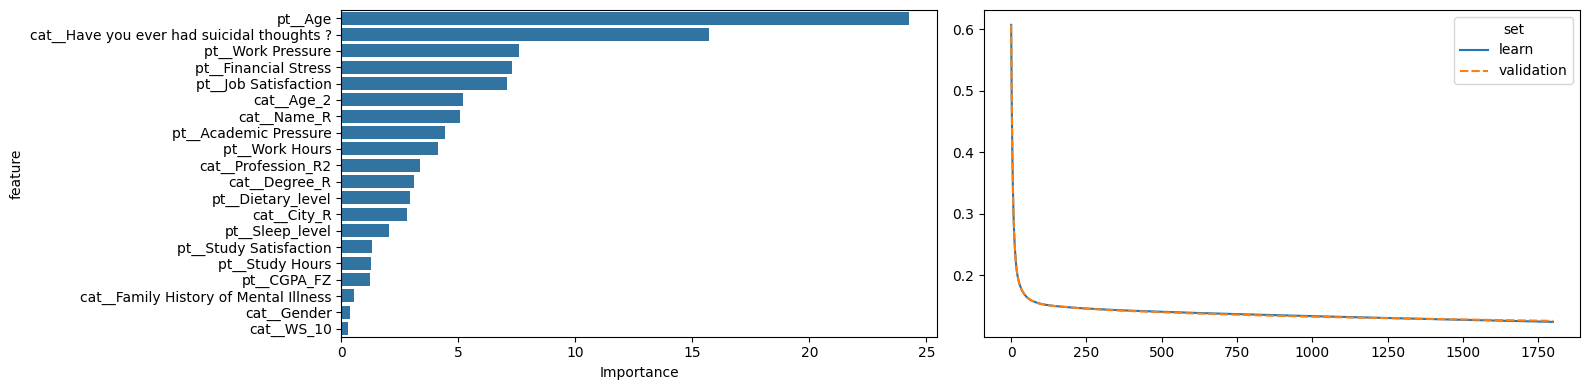

Accuracy, Valid.: 0.94021±0.00171


In [269]:
result = cb3.cv(df_train, hparams)
show_result_lgb(result)
print_metrics('Valid.', result['valid_scores'])

In [270]:
with pd.option_context('display.max_colwidth', 500):
    display(pd.Series(cb3.cv_best_['hparams']).rename('value').to_frame())
print(cb3.cv_best_['score'])

,value
model_params,"{'n_estimators': 1800, 'learning_rate': 0.05, 'max_depth': 6, 'rsm': 0.5}"
X_num,"[Age, Academic Pressure, Financial Stress, Work Pressure, Study Satisfaction, Job Satisfaction, Work Hours, Study Hours, CGPA_FZ, Dietary_level, Sleep_level]"
X_cat,"[Name_R, Have you ever had suicidal thoughts ?, WS_10, Family History of Mental Illness, Degree_R, City_R, Profession_R2, Age_2, Gender]"


0.9402061122956645


# CB + LDA

In [271]:
cv_path = os.path.join('result', 'CB_LDA.cv')
if os.path.exists(cv_path):
    cb_lda = sgml.CVModel.load('result', 'CB_LDA')
else:
    cb_lda = sgml.CVModel('result', 'CB_LDA', skf, config, cb_adapter)

In [272]:
hparams = {
    'model_params': {'n_estimators': 2500, 'learning_rate': 0.07, 'max_depth': 3},
    'X_num':  [
        'Age', 'Academic Pressure', 'Financial Stress', 'Work Pressure', 'Study Satisfaction', 'Job Satisfaction', 'Work Hours', 
        'Study Hours', 'Dietary_level', 'Sleep_level'
    ],
    'X_cat': ['Name_R', 'Have you ever had suicidal thoughts ?', 'WS_10', 'Family History of Mental Illness', 'Degree_R', 'City_R', 'Profession_R2', 'Age_2', 'Gender'],
    'lda': {
        'X_mm':  [
            'Academic Pressure_FZ', 'Study Hours', 'CGPA_FZ', 'Work Hours', 'Academic Pressure_FZ', 'Financial Stress_FM', 'Work Pressure_FZ', 'Study Satisfaction_FZ', 'Job Satisfaction_FZ',
        ],
        'X_ohe': ['Have you ever had suicidal thoughts ?'], 'ohe': {'drop': 'first', 'sparse_output': False}
    },
    #'validation_fraction': 0.1
}
# result = cb_lda.adhoc(df_train, ss, hparams)
# show_result_lgb(result)
# print(result['train_scores'], result['valid_scores'])

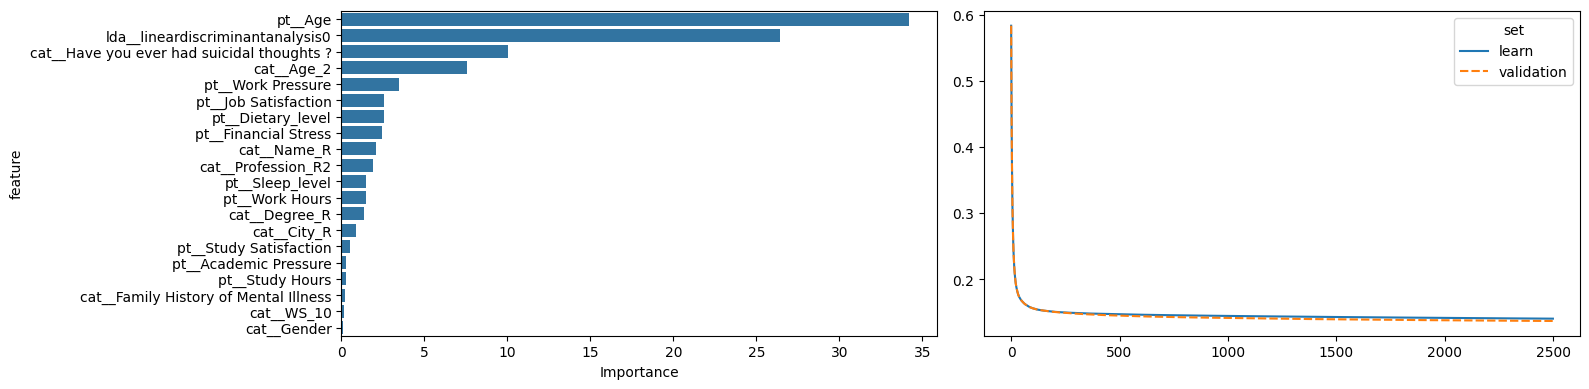

Accuracy, Valid.: 0.94055±0.00149


In [273]:
result = cb_lda.cv(df_train, hparams)
show_result_lgb(result)
print_metrics('Valid.', result['valid_scores'])

In [274]:
with pd.option_context('display.max_colwidth', 500):
    display(pd.Series(cb_lda.cv_best_['hparams']).rename('value').to_frame())
print(cb_lda.cv_best_['score'])

,value
model_params,"{'n_estimators': 2500, 'learning_rate': 0.07, 'max_depth': 3}"
X_num,"[Age, Academic Pressure, Financial Stress, Work Pressure, Study Satisfaction, Job Satisfaction, Work Hours, Study Hours, Dietary_level, Sleep_level]"
X_cat,"[Name_R, Have you ever had suicidal thoughts ?, WS_10, Family History of Mental Illness, Degree_R, City_R, Profession_R2, Age_2, Gender]"
lda,"{'X_mm': ['Academic Pressure_FZ', 'Study Hours', 'CGPA_FZ', 'Work Hours', 'Academic Pressure_FZ', 'Financial Stress_FM', 'Work Pressure_FZ', 'Study Satisfaction_FZ', 'Job Satisfaction_FZ'], 'X_ohe': ['Have you ever had suicidal thoughts ?'], 'ohe': {'drop': 'first', 'sparse_output': False}}"


0.940547263681592


# Stacking

In [275]:
models = [lr, lgb1, lgb2, xgb1, xgb2, cb1, cb2, cb3, nn1, xgb_lda, lgb_lda, cb_lda]
pd.Series([i.cv_best_['score'] for i in models], index=[i.name for i in models]).sort_values(ascending=False).to_frame().T

,CB1,CB_LDA,CB2,LGB1,LGB2,XGB1,XGB_LDA,XGB2,CB3,LGB_LDA,NN1,LR
0,0.940725,0.940547,0.940441,0.940434,0.940334,0.94032,0.94027,0.940242,0.940206,0.940071,0.939424,0.939254


In [276]:
df_stk = sgml.stack_cv(models, df_train[target]).sort_index()
df_stk.corr()

,LR,LGB1,LGB2,XGB1,XGB2,CB1,CB2,CB3,NN1,XGB_LDA,LGB_LDA,CB_LDA,Depression
LR,1.000000,0.994376,0.994685,0.994145,0.994266,0.991800,0.991641,0.990975,0.998134,0.994231,0.994810,0.992493,0.836811
LGB1,0.994376,1.000000,0.999261,0.997215,0.996914,0.995820,0.995594,0.995257,0.993613,0.996561,0.998583,0.995872,0.839538
LGB2,0.994685,0.999261,1.000000,0.996855,0.996692,0.995525,0.995416,0.994893,0.993800,0.996338,0.998815,0.995700,0.839495
XGB1,0.994145,0.997215,0.996855,1.000000,0.998060,0.994702,0.994439,0.994188,0.993462,0.997268,0.996424,0.994561,0.839224
XGB2,0.994266,0.996914,0.996692,0.998060,1.000000,0.994348,0.994187,0.993792,0.993522,0.997831,0.996226,0.994286,0.839053
CB1,0.991800,0.995820,0.995525,0.994702,0.994348,1.000000,0.998022,0.998924,0.990931,0.993788,0.995252,0.998075,0.839482
CB2,0.991641,0.995594,0.995416,0.994439,0.994187,0.998022,1.000000,0.997465,0.990617,0.993661,0.995111,0.997434,0.839168
CB3,0.990975,0.995257,0.994893,0.994188,0.993792,0.998924,0.997465,1.000000,0.990206,0.993202,0.994597,0.997417,0.839396
NN1,0.998134,0.993613,0.993800,0.993462,0.993522,0.990931,0.990617,0.990206,1.000000,0.993567,0.993886,0.991537,0.836428
XGB_LDA,0.994231,0.996561,0.996338,0.997268,0.997831,0.993788,0.993661,0.993202,0.993567,1.000000,0.996116,0.994209,0.838932


In [277]:
(
    accuracy_score(
        df_stk['Depression'],
        df_stk[['CB1', 'CB2', 'CB3', 'XGB1', 'XGB2', 'LGB1', 'LGB2', 'LGB_LDA', 'CB_LDA', 'XGB_LDA']].mean(axis=1) >= 0.5
    ),
    accuracy_score(
        df_stk['Depression'],
        df_stk[['CB1', 'CB2', 'CB3', 'XGB1', 'LGB1', 'LGB2', 'LGB_LDA']].mean(axis=1) >= 0.5
    ),
    roc_auc_score(
        df_stk['Depression'],
        df_stk[['CB1', 'CB2', 'CB3', 'XGB1', 'XGB2', 'LGB1', 'LGB2', 'LGB_LDA', 'CB_LDA', 'XGB_LDA']].mean(axis=1)
    ), 
    roc_auc_score(
        df_stk['Depression'],
        df_stk[['CB1', 'CB2', 'CB3', 'XGB1', 'LGB1', 'LGB2', 'LGB_LDA']].mean(axis=1)
    )
)

(0.9406396588486141,
 0.9407675906183369,
 0.9763480374306187,
 0.9763122496855611)

In [278]:
from sklearn.linear_model import LogisticRegression
lr_adapter = sgml.SklearnAdapter(LogisticRegression)

cv_path = os.path.join('result', 'stk_lr.cv')
if os.path.exists(cv_path):
    stk = sgml.CVModel.load('result', 'stk_lr')
else:
    skf2 = StratifiedKFold(n_splits=5, random_state=12, shuffle=True)
    stk = sgml.CVModel('result', 'stk_lr', skf2, config, lr_adapter)

In [279]:
hparams={
    'model_params' : {'C': 10},
    'X_num': ['CB1', 'CB2', 'CB3', 'XGB1', 'XGB2', 'LGB1', 'LGB2', 'LGB_LDA', 'CB_LDA', 'XGB_LDA']
}
result = stk.cv(df_stk, hparams, result_proc=sgml.m_learning_result, rerun=1)
print_metrics('Valid. score', result['valid_scores'])

Fold:   0%|          | 0/5 [00:00<?, ?it/s]

Accuracy, Valid. score: 0.94043±0.00160


In [280]:
pd.concat(
    [pd.Series(i['model'].coef_[0], index=i['variables']) for i in result['model_result']], axis=1
)

,0,1,2,3,4
CB1,0.750092,0.749966,0.748916,0.748027,0.745216
CB_LDA,0.752726,0.760901,0.753338,0.750409,0.755293
XGB1,0.735244,0.734434,0.730481,0.737690,0.738164
XGB_LDA,0.733555,0.737329,0.729146,0.737731,0.737974
LGB1,0.729443,0.731416,0.727961,0.733777,0.729245
XGB2,0.733099,0.732263,0.730476,0.740022,0.737336
CB3,0.755660,0.756450,0.758988,0.753451,0.752536
LGB_LDA,0.732651,0.729954,0.733198,0.730397,0.730646
LGB2,0.734144,0.733707,0.731126,0.733219,0.730079
CB2,0.741856,0.744284,0.746668,0.743610,0.743143


In [281]:
df_confuse = df_train.loc[
    stk.cv_best_['prd'].sort_index().between(0.3, 0.7)
].assign(
    prob = lambda x: stk.cv_best_['prd']
)

In [282]:
len(df_confuse) / len(df_train), roc_auc_score(df_confuse[target], df_confuse['prob'])

(0.03547974413646055, 0.5717164358124617)

In [283]:
df_confuse[target].value_counts()

Depression
1    2695
0    2297
Name: count, dtype: int64

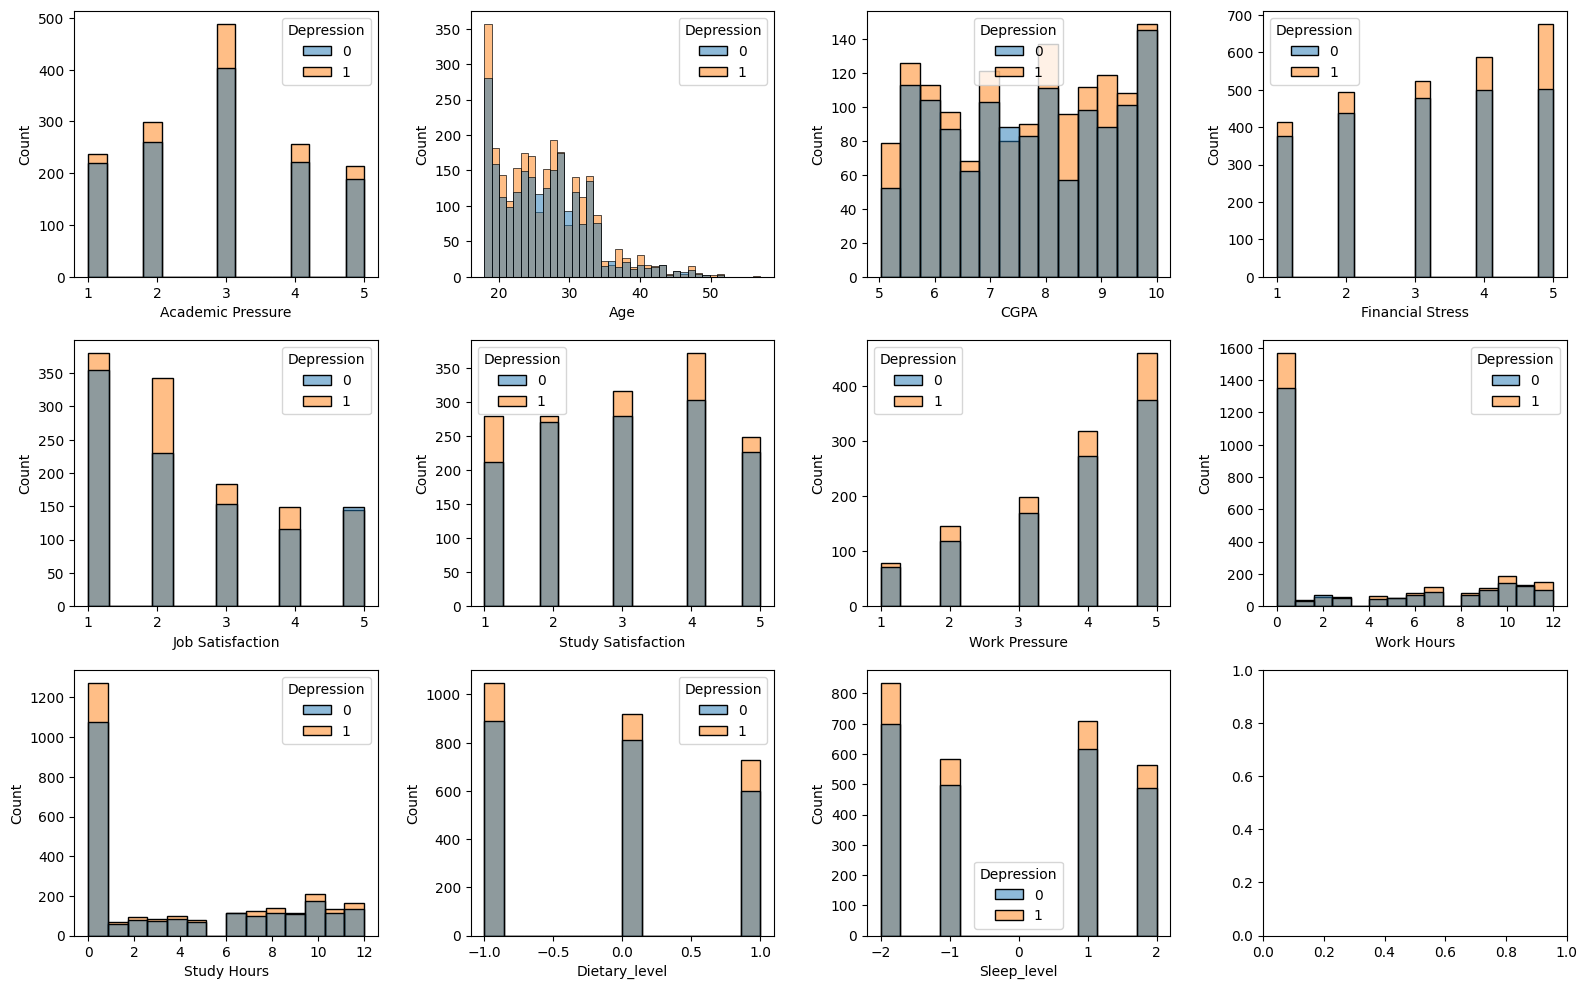

In [284]:
X_cont = ['Academic Pressure', 'Age', 'CGPA',  'Financial Stress', 'Job Satisfaction', 'Study Satisfaction',  'Work Pressure', 
          'Work Hours', 'Study Hours', 'Dietary_level', 'Sleep_level']
fig, axes = plt.subplots(3, 4, figsize=(16, 10))
for i, ax in zip(X_cont, axes.flatten()):
    sns.histplot(df_confuse, x=i, hue=target, ax=ax)
plt.tight_layout()
plt.show()

In [285]:
pd.concat([
    df_confuse['Profession_R2'].value_counts().rename('confuse'),
    df_train['Profession_R2'].value_counts().rename('train'),
    df_confuse.groupby('Profession_R2', observed=True)[target].mean().rename('confuse_target'), 
    df_train.groupby('Profession_R2', observed=True)[target].mean().rename('train_target'), 
    df_confuse.groupby('Profession_R2', observed=True)[target].sum().rename('confuse_target_cnt'),
    df_train.groupby('Profession_R2', observed=True)[target].sum().rename('train_target_cnt'),
], axis=1).assign(
    ratio = lambda x: x['confuse'] / x['train']
).sort_values('confuse', ascending=False).iloc[:10]

,confuse,train,confuse_target,train_target,confuse_target_cnt,train_target_cnt,ratio
Profession_R2,,,,,,,
Student,2787,27905,0.536060,0.585415,1494,16336,0.099875
Unknown,658,8763,0.534954,0.375100,352,3287,0.075088
Teacher,348,24900,0.534483,0.055462,186,1381,0.013976
Architect,92,4362,0.565217,0.097662,52,426,0.021091
HR Manager,84,4022,0.583333,0.106912,49,430,0.020885
Consultant,63,4229,0.571429,0.047056,36,199,0.014897
Data Scientist,54,2390,0.574074,0.077824,31,186,0.022594
Educational Consultant,50,2851,0.440000,0.074360,22,212,0.017538
Judge,49,1712,0.571429,0.108645,28,186,0.028621


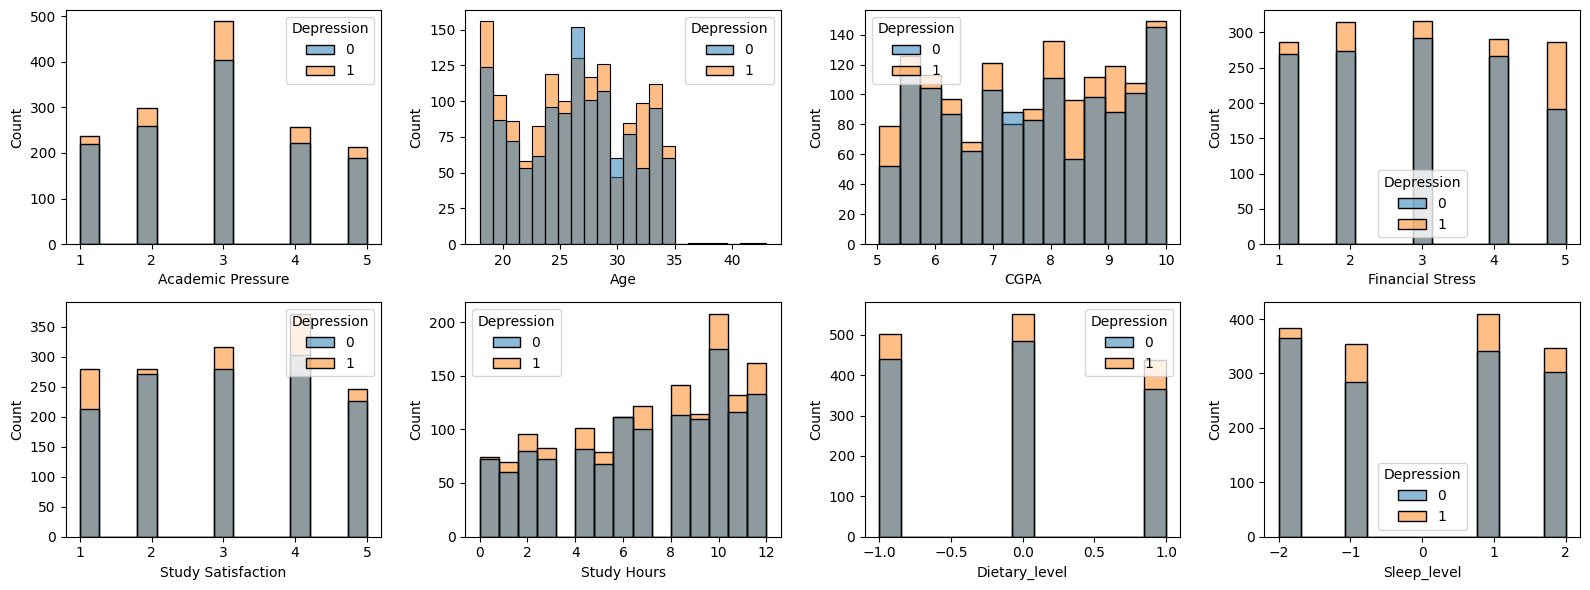

In [286]:
X_cont = ['Academic Pressure', 'Age', 'CGPA',  'Financial Stress', 'Study Satisfaction', 
          'Study Hours', 'Dietary_level', 'Sleep_level']
fig, axes = plt.subplots(2, 4, figsize=(16, 6))
df_confuse_student = df_confuse.loc[df_confuse['Profession_R2'] == 'Student']
for i, ax in zip(X_cont, axes.flatten()):
    sns.histplot(df_confuse_student, x=i, hue=target, ax=ax)
plt.tight_layout()
plt.show()

In [287]:
df_confuse_student.pivot_table(index='Gender',  columns=target, aggfunc='size', observed=True)

Depression,0,1
Gender,,
Female,610,671
Male,683,823


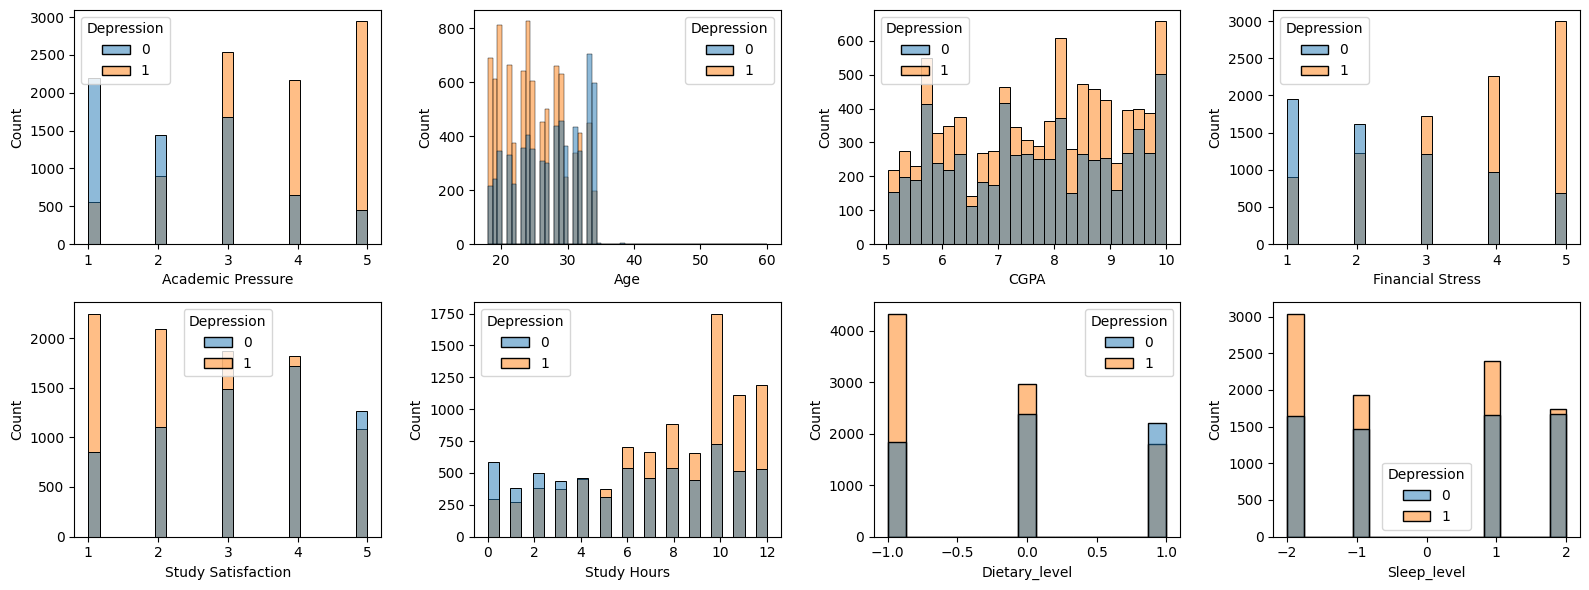

In [288]:
X_cont = ['Academic Pressure', 'Age', 'CGPA',  'Financial Stress', 'Study Satisfaction', 
          'Study Hours', 'Dietary_level', 'Sleep_level']
fig, axes = plt.subplots(2, 4, figsize=(16, 6))
df_train_student_male = df_train.loc[(df_train['Profession_R2'] == 'Student') & (df_train['Gender'] == 'Male')]
for i, ax in zip(X_cont, axes.flatten()):
    sns.histplot(df_train_student_male, x=i, hue=target, ax=ax)
plt.tight_layout()
plt.show()

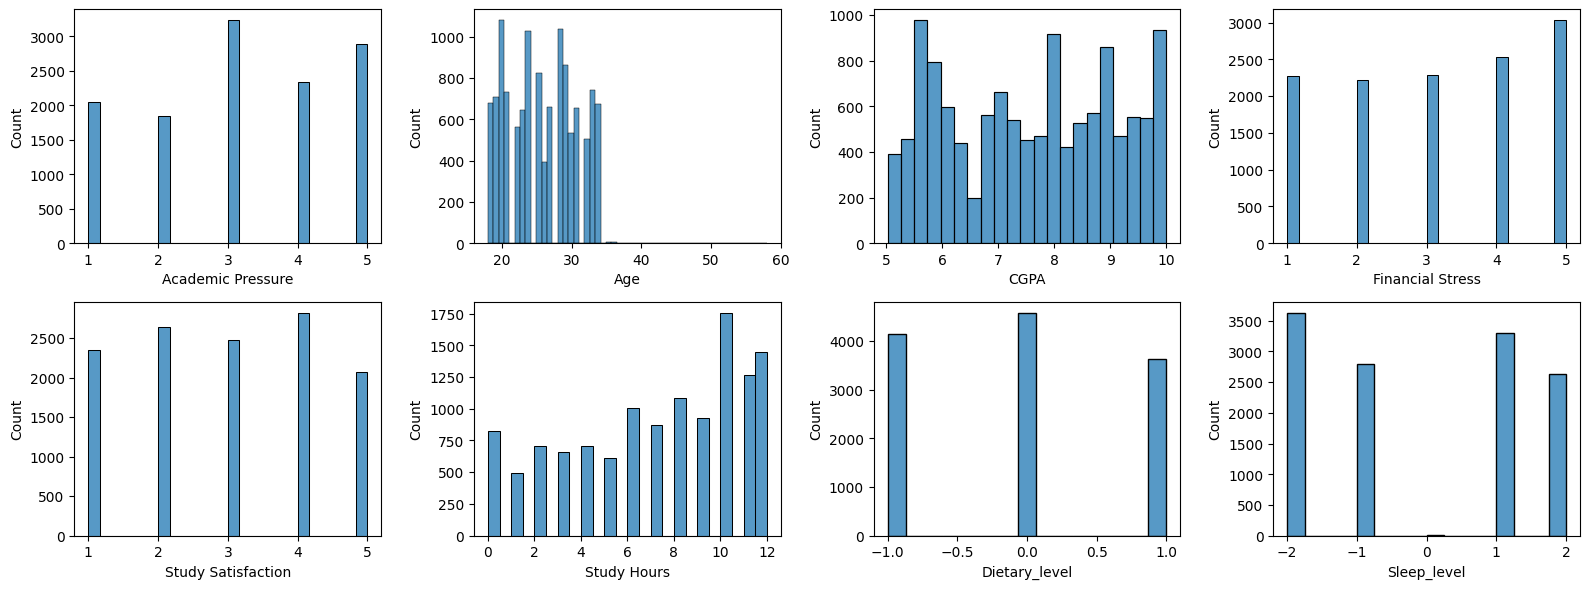

In [316]:
X_cont = ['Academic Pressure', 'Age', 'CGPA',  'Financial Stress', 'Study Satisfaction', 
          'Study Hours', 'Dietary_level', 'Sleep_level']
fig, axes = plt.subplots(2, 4, figsize=(16, 6))
df_train_student_female = df_train.loc[(df_train['Profession_R2'] == 'Student') & (df_train['Gender'] == 'Female')]
for i, ax in zip(X_cont, axes.flatten()):
    sns.histplot(df_train_student_female, x=i, ax=ax)
plt.tight_layout()
plt.show()

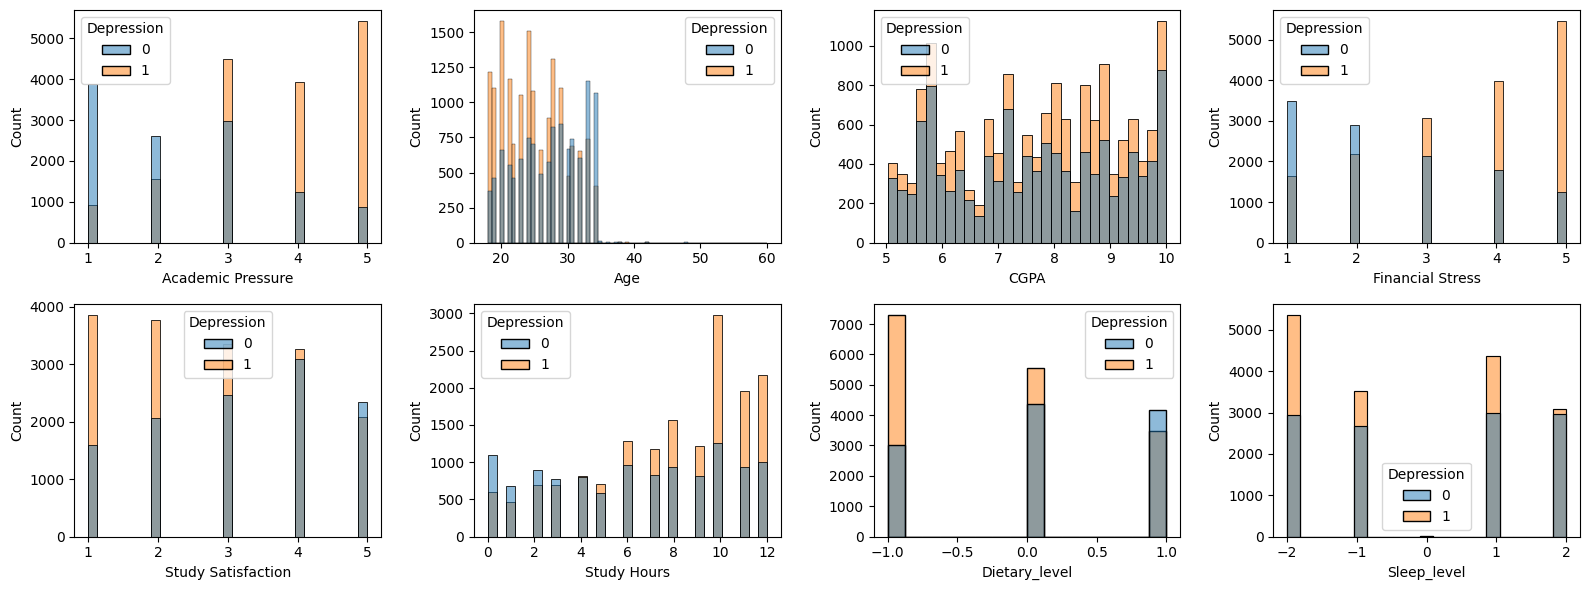

In [292]:
X_cont = ['Academic Pressure', 'Age', 'CGPA',  'Financial Stress', 'Study Satisfaction', 
          'Study Hours', 'Dietary_level', 'Sleep_level']
fig, axes = plt.subplots(2, 4, figsize=(16, 6))
df_train_student = df_train.loc[df_train['Profession_R2'] == 'Student']
for i, ax in zip(X_cont, axes.flatten()):
    sns.histplot(df_train_student, x=i, hue=target, ax=ax)
plt.tight_layout()
plt.show()

In [313]:
df_train_student['Age'].value_counts()

Age
24.0    2258
20.0    2237
28.0    2133
29.0    1951
33.0    1893
25.0    1784
21.0    1726
23.0    1645
18.0    1587
19.0    1560
34.0    1468
27.0    1462
31.0    1427
32.0    1262
22.0    1161
26.0    1155
30.0    1145
35.0      11
38.0       8
36.0       7
42.0       4
48.0       3
39.0       3
43.0       2
46.0       2
37.0       2
49.0       1
51.0       1
60.0       1
44.0       1
59.0       1
54.0       1
58.0       1
56.0       1
41.0       1
Name: count, dtype: int64

In [338]:
from scipy.stats import f_oneway
df_train_student[['Degree_R', 'City_R']].apply(
    lambda x: f_oneway(*df_train_student.groupby(x, observed=True)['CGPA'].agg(lambda x: list(x.dropna()))),
    axis=0
)

,Degree_R,City_R
0,6.030341e+00,9.753877e+00
1,2.752665e-21,1.402707e-44


In [311]:
df_train_student.pivot_table(index='Age', columns='Degree_R', values=target, aggfunc='mean', observed=True).iloc[:20]

Degree_R,Noise,Class 12,B.Ed,B.Arch,B.Com,B.Pharm,BCA,M.Ed,MCA,BBA,...,MBA,BA,ME,MD,MHM,BE,PhD,M.Com,MBBS,MA
Age,,,,,,,,,,,,,,,,,,,,,
18.0,1.000000,0.766646,1.000000,NaN,NaN,NaN,0.000000,NaN,1.000000,NaN,...,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,0.500000,NaN,1.000000
19.0,1.000000,0.704971,NaN,0.000000,NaN,NaN,1.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.000000,NaN
20.0,1.000000,0.707973,0.000000,NaN,0.500000,NaN,1.000000,1.000000,0.000000,NaN,...,1.000000,0.500000,NaN,NaN,NaN,1.000000,NaN,1.000000,0.500000,0.500000
21.0,NaN,0.730000,0.696629,0.700000,0.704545,0.588235,0.680272,0.761905,0.659389,0.763158,...,0.647059,0.648649,1.000000,0.714286,0.500000,0.727273,0.400000,0.633333,0.571429,0.676923
22.0,0.000000,0.538462,0.652174,0.534884,0.573427,0.625000,0.696774,0.857143,0.584270,0.606742,...,0.578947,0.538462,0.333333,1.000000,0.333333,0.478261,0.500000,0.582090,0.777778,0.350000
23.0,0.333333,0.875000,0.629213,0.642857,0.645833,0.500000,0.584158,0.500000,0.625000,0.611940,...,0.690476,0.557692,0.000000,0.600000,0.333333,0.604651,0.625000,0.566667,0.705882,0.729730
24.0,1.000000,0.698225,0.691489,0.658307,0.720930,0.610294,0.763441,0.566667,0.618182,0.696970,...,0.642857,0.572816,0.500000,0.700000,0.625000,0.605263,0.300000,0.666667,0.676923,0.464286
25.0,0.000000,0.586957,0.663594,0.563953,0.645833,0.575000,0.600000,0.597015,0.620000,0.511111,...,0.677419,0.428571,0.500000,0.550000,0.656250,0.604651,0.647887,0.580645,0.617647,0.621622
26.0,0.000000,0.486486,0.580000,0.509091,0.616438,0.631579,0.580000,0.640000,0.648148,0.637500,...,0.363636,0.540541,0.600000,0.500000,0.333333,0.571429,0.730769,0.555556,0.666667,0.344828


<Axes: xlabel='Academic Pressure', ylabel='Study Hours'>

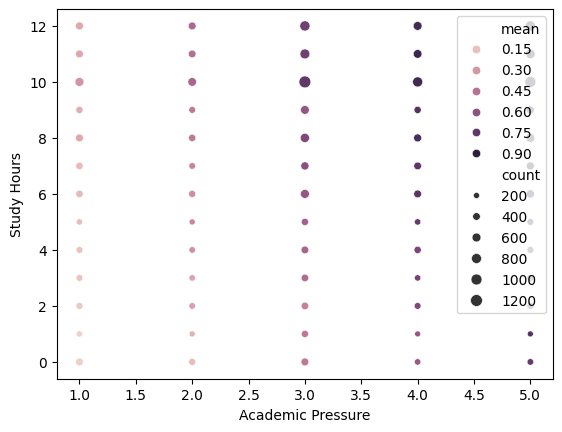

In [298]:
df_train_student.groupby(['Academic Pressure','Study Hours'], as_index=False)[target].agg(['mean', 'count']).pipe(
    lambda x: sns.scatterplot(x, x='Academic Pressure', y = 'Study Hours', hue='mean', size='count')
)

<Axes: xlabel='Study Satisfaction', ylabel='Study Hours'>

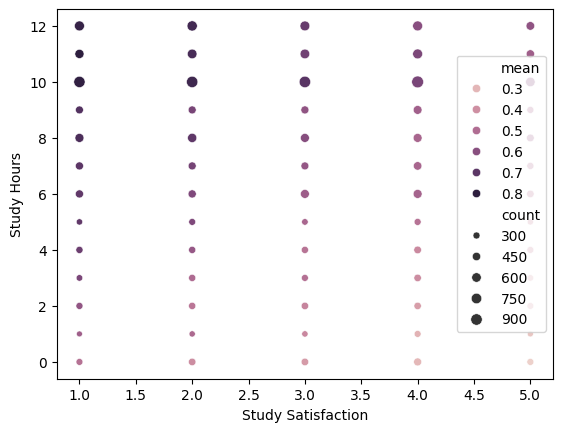

In [299]:
df_train_student.groupby(['Study Satisfaction','Study Hours'], as_index=False)[target].agg(['mean', 'count']).pipe(
    lambda x: sns.scatterplot(x, x='Study Satisfaction', y = 'Study Hours', hue='mean', size='count')
)

In [301]:
df_train_student[X_cont].corr().loc['Academic Pressure']

Academic Pressure     1.000000
Age                  -0.076017
CGPA                 -0.025167
Financial Stress      0.152066
Study Satisfaction   -0.112216
Study Hours           0.095712
Dietary_level        -0.089293
Sleep_level          -0.040576
Name: Academic Pressure, dtype: float64

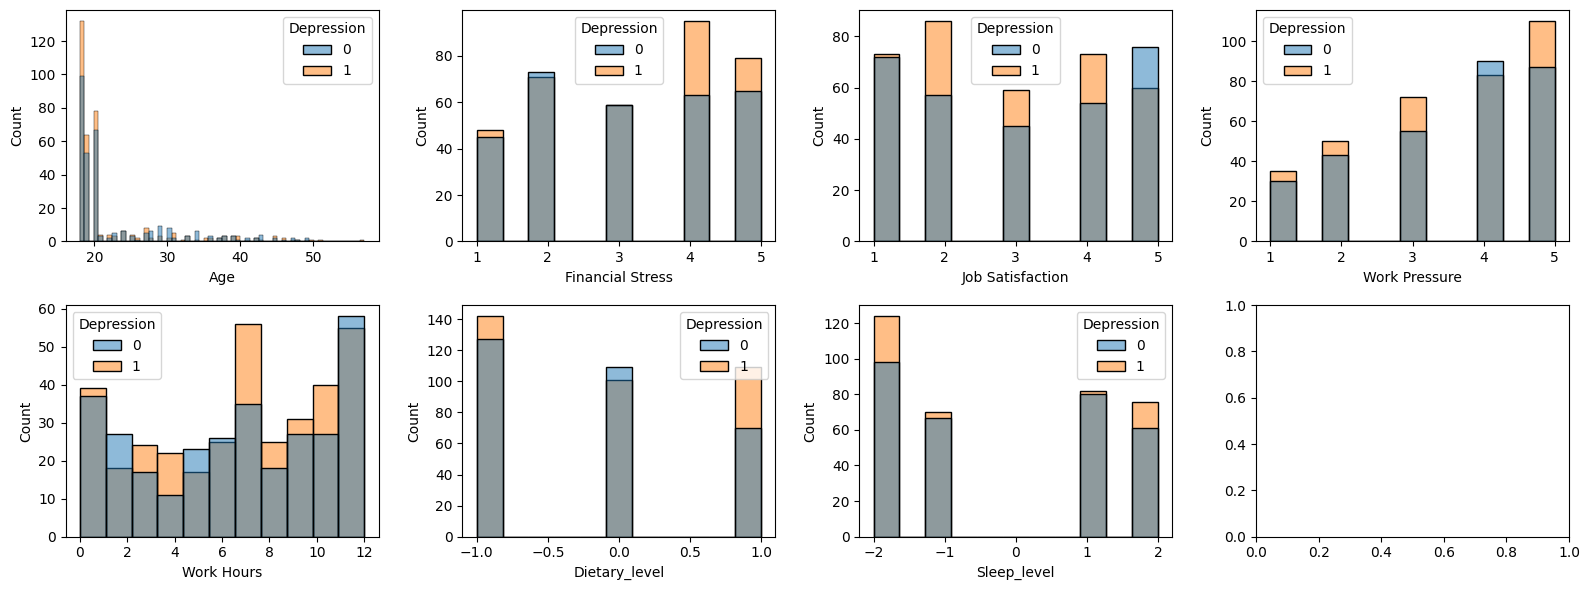

In [104]:
X_cont = ['Age', 'Financial Stress', 'Job Satisfaction', 'Work Pressure', 
          'Work Hours', 'Dietary_level', 'Sleep_level']
fig, axes = plt.subplots(2, 4, figsize=(16, 6))
df_confuse_unknown = df_confuse.loc[df_confuse['Profession_R2'].isin(['Unknown'])]
for i, ax in zip(X_cont, axes.flatten()):
    sns.histplot(df_confuse_unknown, x=i, hue=target, ax=ax)
plt.tight_layout()
plt.show()

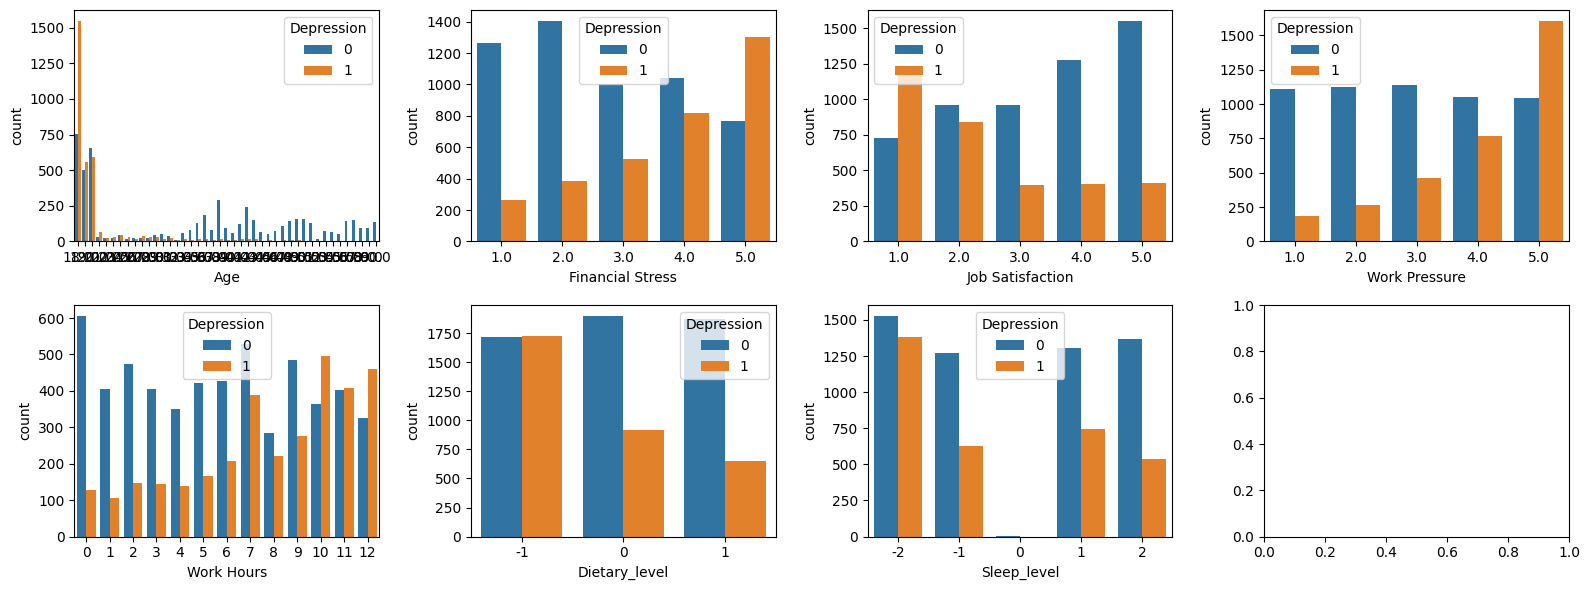

In [107]:
X_cont = ['Age', 'Financial Stress', 'Job Satisfaction', 'Work Pressure', 
          'Work Hours', 'Dietary_level', 'Sleep_level']
fig, axes = plt.subplots(2, 4, figsize=(16, 6))
df_train_unknown = df_train.loc[df_train['Profession_R2'].isin(['Unknown'])]
for i, ax in zip(X_cont, axes.flatten()):
    sns.countplot(df_train_unknown, x=i, hue=target, ax=ax)
plt.tight_layout()
plt.show()

In [109]:
df_train_unknown.pivot_table(index='Age', columns=target, aggfunc='size').iloc[:5]

Depression,0,1
Age,,
18.0,757.0,1547.0
19.0,499.0,554.0
20.0,656.0,593.0
21.0,33.0,66.0
22.0,22.0,21.0


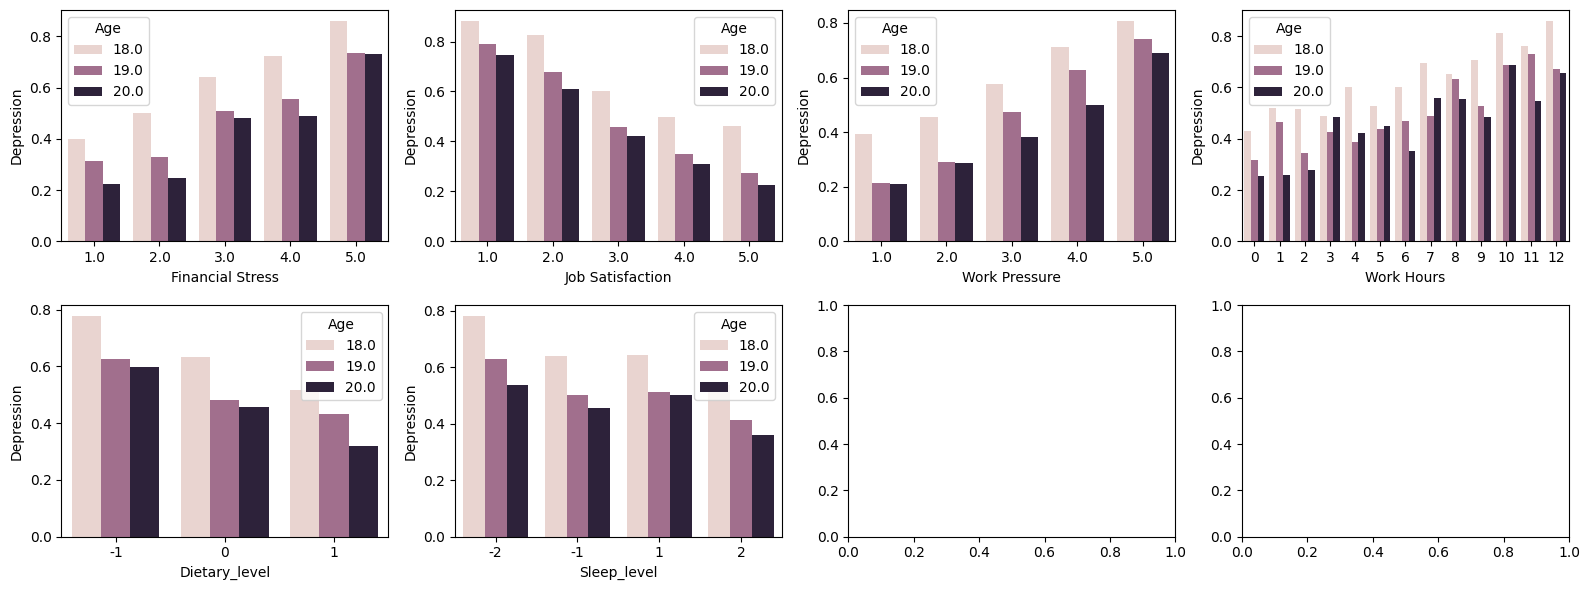

In [193]:
X_cont = ['Financial Stress', 'Job Satisfaction', 'Work Pressure', 
          'Work Hours', 'Dietary_level', 'Sleep_level']
fig, axes = plt.subplots(2, 4, figsize=(16, 6))
df_train_unknown_20 = df_train.loc[(df_train['Profession_R2'] == 'Unknown') & (df_train['Age'] <= 20)]
for i, ax in zip(X_cont, axes.flatten()):
    sns.barplot(df_train_unknown_20.groupby(['Age', i], as_index=False)[target].mean(), x=i, y=target, hue='Age', ax=ax)
plt.tight_layout()
plt.show()

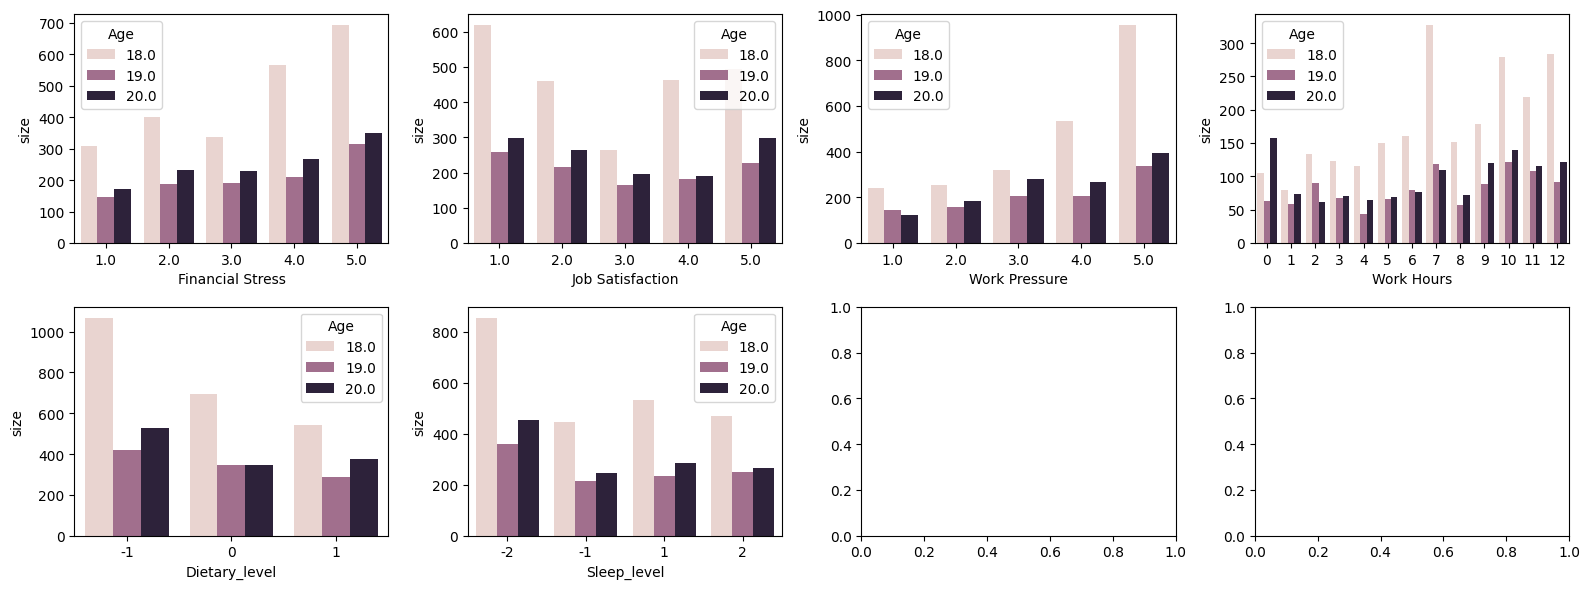

In [196]:
X_cont = ['Financial Stress', 'Job Satisfaction', 'Work Pressure', 
          'Work Hours', 'Dietary_level', 'Sleep_level']
fig, axes = plt.subplots(2, 4, figsize=(16, 6))
df_train_unknown_20 = df_train.loc[(df_train['Profession_R2'] == 'Unknown') & (df_train['Age'] <= 20)]
for i, ax in zip(X_cont, axes.flatten()):
    sns.barplot(df_train_unknown_20.groupby(['Age', i], as_index=False).size(), x=i, y='size', hue='Age', ax=ax)
plt.tight_layout()
plt.show()

In [206]:
df_train_not_student.groupby('Work Pressure')['Work Hours'].agg(['mean', 'std', 'count'])

,mean,std,count
Work Pressure,,,
1.0,6.326104,3.700588,1291
2.0,6.127965,3.729642,1391
3.0,6.199375,3.786633,1600
4.0,6.425344,3.878505,1815
5.0,6.782477,3.832274,2648


In [207]:
df_train_not_student.groupby('Job Satisfaction')['Work Hours'].agg(['mean', 'std', 'count'])

,mean,std,count
Job Satisfaction,,,
1.0,7.042008,3.724808,1952
2.0,6.566907,3.804981,1801
3.0,6.224761,3.852215,1357
4.0,6.158711,3.772468,1676
5.0,6.072922,3.806451,1961


In [208]:
df_train_not_student.groupby('Work Pressure')['Job Satisfaction'].agg(['mean', 'std', 'count'])

,mean,std,count
Work Pressure,,,
1.0,3.200155,1.426338,1289
2.0,3.102085,1.475825,1391
3.0,3.078125,1.447267,1600
4.0,2.926681,1.467660,1814
5.0,2.811414,1.510004,2646


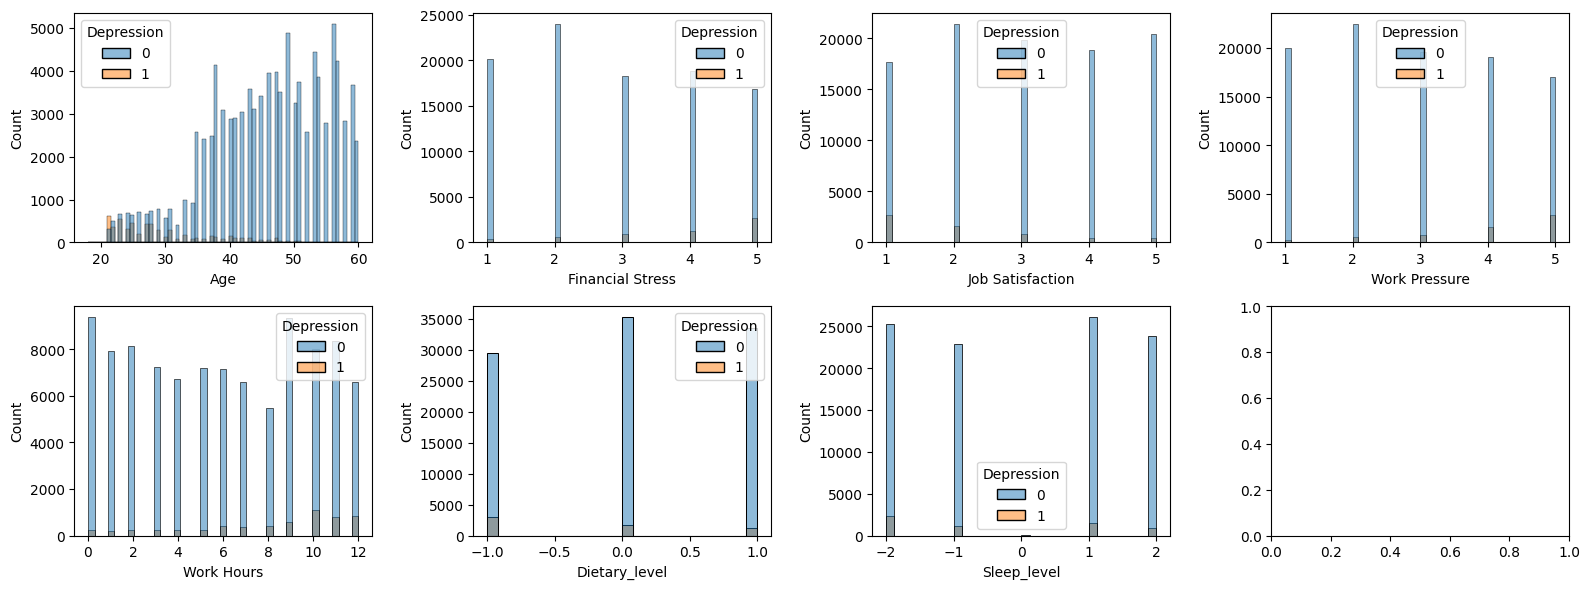

In [99]:
X_cont = ['Age', 'Financial Stress', 'Job Satisfaction', 'Work Pressure', 
          'Work Hours', 'Dietary_level', 'Sleep_level']
fig, axes = plt.subplots(2, 4, figsize=(16, 6))
df_train_not_student = df_train.loc[~df_train['Profession_R2'].isin(['Student', 'Unknown'])]
for i, ax in zip(X_cont, axes.flatten()):
    sns.histplot(df_train_not_student, x=i, hue=target, ax=ax)
plt.tight_layout()
plt.show()

In [ ]:
hparams = {
    'model_params': {'n_estimators': 100, 'num_leaves': 3},
    'X_num':  [
       'Financial Stress_FM'
    ],
    'X_ohe': ['Family History of Mental Illness', 'Gender'],
    'ohe': {'min_frequency': 10, 'drop': 'if_binary', 'handle_unknown': 'ignore'},
}
result = lgb1.adhoc(df_confuse, StratifiedKFold(5), hparams)

In [ ]:
(
    result['model_result'][0]['feature_importance'][-20:], 
    result['train_scores'], result['valid_scores'], 
    roc_auc_score(df_confuse[target].sort_index(), result['valid_prd'].sort_index())
)

In [ ]:
df_train.pivot_table(index=['Family History of Mental Illness', 'Gender'], columns=target, aggfunc='size', observed=False).assign(
    ratio = lambda x: x[1] / x.sum(axis=1)
)

In [ ]:
df_confuse.pivot_table(index=['Family History of Mental Illness', 'Gender'], columns=target, aggfunc='size', observed=False).assign(
    ratio = lambda x: x[1] / x.sum(axis=1)
)

In [ ]:
for i in models:
    i.train(df_train)

In [ ]:
df_test = pl.read_parquet(files['test_parquet'])
df_test = df_test.to_pandas().set_index('id')

In [ ]:
df_test, nq = dproc.apply_pd_procs(df_test, df_var.loc[df_var['processor'].notna(), 'processor'])
df_test

In [ ]:
df_stk_test = sc.cache_result(
    'stk_test',
    lambda : sgml.stack_prd(models, df_test, config)
)
df_stk_test.head()

In [ ]:
stk.train(df_stk)

In [ ]:
stk.get_predictor()(df_stk_test)